In [9]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [10]:
def available_black(board):
    """Return move dictionary for black (-1) pieces"""
    d = defaultdict(lambda: np.zeros(4))
    n = 8

    for i in range(n):
        for j in range(n):
            if board[i][j] < 0:  # Black pieces
                # Forward-left (up the board)
                if i-1 >= 0 and j-1 >= 0:
                    if board[i-1][j-1] == 0:
                        d[i, j][0] = 1
                    elif board[i-1][j-1] > 0 and i-2 >= 0 and j-2 >= 0 and board[i-2][j-2] == 0:
                        d[i, j][0] = 1
                # Forward-right
                if i-1 >= 0 and j+1 < n:
                    if board[i-1][j+1] == 0:
                        d[i, j][1] = 1
                    elif board[i-1][j+1] > 0 and i-2 >= 0 and j+2 < n and board[i-2][j+2] == 0:
                        d[i, j][1] = 1
                # Backward-left (only for kings)
                if board[i][j] == -2 and i+1 < n and j-1 >= 0:
                    if board[i+1][j-1] == 0:
                        d[i, j][2] = 1
                    elif board[i+1][j-1] > 0 and i+2 < n and j-2 >= 0 and board[i+2][j-2] == 0:
                        d[i, j][2] = 1
                # Backward-right (only for kings)
                if board[i][j] == -2 and i+1 < n and j+1 < n:
                    if board[i+1][j+1] == 0:
                        d[i, j][3] = 1
                    elif board[i+1][j+1] > 0 and i+2 < n and j+2 < n and board[i+2][j+2] == 0:
                        d[i, j][3] = 1
    return d

def get_valid_moves_for_black(board):
    """Return list of valid moves for black (-1)"""
    d = available_black(board)
    move_list = []
    for pos, arr in d.items():
        for i, val in enumerate(arr):
            if val == 1:
                move_list.append((pos, i))
    return move_list

def possible_cap_black(board, i, j):
    """Return possible captures for black piece at (i,j)"""
    d = defaultdict(lambda: np.zeros(4))
    n = 8

    if board[i][j] < 0:
        # Forward-left
        if i-2 >= 0 and j-2 >= 0 and board[i-2][j-2] == 0 and board[i-1][j-1] > 0:
            d[i, j][0] = 1
        # Forward-right
        if i-2 >= 0 and j+2 < n and board[i-2][j+2] == 0 and board[i-1][j+1] > 0:
            d[i, j][1] = 1
        # Backward-left (king)
        if board[i][j] == -2 and i+2 < n and j-2 >= 0 and board[i+2][j-2] == 0 and board[i+1][j-1] > 0:
            d[i, j][2] = 1
        # Backward-right (king)
        if board[i][j] == -2 and i+2 < n and j+2 < n and board[i+2][j+2] == 0 and board[i+1][j+1] > 0:
            d[i, j][3] = 1
    return [((i, j), move) for move, val in enumerate(d[i, j]) if val == 1]

def apply_move_black(board, action):
    """Apply move for black piece (-1)"""
    i, j = action[0]
    move = action[1]

    piece = board[i][j]
    n = 8

    if move == 0:  # forward-left
        if board[i-1][j-1] == 0:
            board[i-1][j-1] = piece
            board[i][j] = 0
        else:  # capture
            board[i-1][j-1] = 0
            board[i-2][j-2] = piece
            board[i][j] = 0
            # Check for multi-capture
            for mv in possible_cap_black(board, i-2, j-2):
                return apply_move_black(board, mv)
    elif move == 1:  # forward-right
        if board[i-1][j+1] == 0:
            board[i-1][j+1] = piece
            board[i][j] = 0
        else:
            board[i-1][j+1] = 0
            board[i-2][j+2] = piece
            board[i][j] = 0
            for mv in possible_cap_black(board, i-2, j+2):
                return apply_move_black(board, mv)
    elif move == 2:  # backward-left
        board[i+1][j-1] = piece
        board[i][j] = 0
    elif move == 3:  # backward-right
        board[i+1][j+1] = piece
        board[i][j] = 0

    # King promotion
    if i-1 == 0 and piece == -1:
        board[i-1][j-1 if move in [0,2] else j+1] = -2

    return board


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CheckersCNN().to(device)

# --------------------------
# Save the model weights
# --------------------------
torch.save(model.state_dict(), "/content/checkers_model_2 (3).pth")

# --------------------------
# Load the model weights
# --------------------------
loaded_model = CheckersCNN().to(device)
state_dict = torch.load("/content/checkers_model_2 (3).pth", map_location=device)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()

CheckersCNN(
  (conv_in): Conv2d(4, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_in): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_blocks): ModuleList(
    (0-7): 8 x ResidualBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (policy_conv): Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1))
  (policy_bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (policy_fc): Linear(in_features=768, out_features=256, bias=True)
  (value_conv): Conv2d(512, 6, kernel_size=(1, 1), stride=(1, 1))
  (value_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (v

In [13]:





def play_vs_agent_black(model=model, human_player=-1, num_simulations=50):
    game = FixedCheckers()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    while game.EndGame() == 0:
        print(game.board)
        if game.current_player == human_player:
            moves = get_valid_moves_for_black(game.board)
            print("Your moves:", moves)
            move_idx = int(input(f"Select move index (0-{len(moves)-1}): "))
            move = moves[move_idx]
            apply_move_black(game.board, move)
            game.switch_player()
        else:
            mcts = MCTS(model, device)
            policy, _ = mcts.search(game, num_simulations=num_simulations)
            valid_moves_dict = game.get_valid_moves()
            valid_moves = game.get_moves(valid_moves_dict)
            # Pick highest probability move
            best_move = max(valid_moves, key=lambda m: policy[m[0][0]*32 + m[0][1]*4 + m[1]])
            game.apply_move(best_move)
            game.switch_player()

    print("Game over:", game.EndGame())
    print(game.board)



In [14]:


play_vs_agent_black()

[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  0  0  1  0  1  0  1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
Your moves: [((5, 0), 1), ((5, 2), 0), ((5, 2), 1), ((5, 4), 0), ((5, 4), 1), ((5, 6), 0), ((5, 6), 1)]
Select move index (0-6): 2
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  0  0  1  0  1  0  1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [-1  0  0  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  0  0  0  0  1  0  1]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [-1  0  0  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
Y

ValueError: invalid literal for int() with base 10: 'y'

In [11]:
class FixedCheckers:
    """Fixed version of your Checkers class"""
    def __init__(self):
        self.board = np.array([
            [0, 1, 0,   1, 0,  1, 0,  1],
            [ 1,  0,  1,  0,  1,  0, 1,  0],
            [0,  1, 0,  1, 0,  1, 0,   1],
            [0,  0, 0,  0, 0,  0, 0,  0],
            [0,  0, 0,  0, 0,  0, 0,  0],
            [-1, 0,  -1, 0,  -1, 0,  -1, 0],
            [0,  -1, 0,  -1, 0,  -1, 0,  -1],
            [ -1, 0,  -1, 0, -1, 0,  -1, 0]
        ], dtype=int)
        self.current_player = 1
    def switch_player(self):
        """Explicitly switch the current player"""
        self.current_player *= -1
    def reverse(self):

      flipped = [row[::-1] for row in self.board[::-1]]

      mapping = {1: -1, 0: 0, 2: -2, -1: 1,0:0  }
      self.board= np.array([[mapping.get(cell, cell) for cell in row] for row in flipped])

      return self.board

    def board_to_tensor(self):

            return board_to_tensor(self.board )


    def copy(self):
        """Create a copy of the game state"""
        new_game = FixedCheckers()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def get_valid_moves(self, player=1):
        """Get valid moves for current player"""
        if player is None:
            player = self.current_player
        return self.available(player)

    def available(self, player=1):
        d = defaultdict(lambda: np.zeros(4))



        if player == 1:  # white pieces
            for i in range(len(self.board)):
                for j in range(len(self.board)):
                    if self.board[i][j] != 0 and self.board[i][j] >= player:
                        # Forward left
                        if i+1 < 8 and j-1 >= 0:
                            if self.board[i+1][j-1] == 0:
                                d[i, j][0] = 1
                            elif self.board[i+1][j-1] <  0:
                                if i+2 < 8 and j-2 >= 0 and self.board[i+2][j-2] == 0:
                                    d[i, j][0] = 1

                        if i+1 < 8 and j+1 < 8:
                            if self.board[i+1][j+1] == 0:
                                d[i, j][1] = 1
                            elif self.board[i+1][j+1] <  0:
                                if i+2 < 8 and j+2 <= 7 and self.board[i+2][j+2] == 0:
                                    d[i,j][1] = 1

                    if self.board[i][j] != 0 and self.board[i][j] > player:
                        # Backward left
                        if i-1 >= 0 and j-1 >= 0:
                            if self.board[i-1][j-1] == 0:
                                d[i, j][2] = 1
                            elif self.board[i-1][j-1]  < 0:
                                if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                                    d[i, j][2] = 1
                        # Backward right
                        if i-1 >= 0 and j+1 < 8:
                            if self.board[i-1][j+1] == 0:
                                d[i, j][3] = 1
                            elif self.board[i-1][j+1]  < 0:
                                if i-2 >= 0 and j+2 < 8 and self.board[i-2][j+2] == 0:
                                    d[i, j][3] = 1
        return d


    def apply_move(self, action, player=1 ):

      i, j = action[0]
      move = action[1]

      if player == 1:  # White player
        if move == 0:  # forward-left
            if self.board[i+1][j-1] == 0:
                self.board[i+1][j-1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j-1] == 1:
                    self.board[i+1][j-1] += 1

            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j-1]

                self.board[i+1][j-1] = 0
                self.board[i+2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j-2] == 1:
                    self.board[i+2][j-2] += 1

                act = self.Possible_cap(i+2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 1:  # forward-right
            if self.board[i+1][j+1] == 0:
                self.board[i+1][j+1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j+1] == 1:
                    self.board[i+1][j+1] += 1
                    # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j+1]
                   # Remove from black's score

                self.board[i+1][j+1] = 0
                self.board[i+2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j+2] == 1:
                    self.board[i+2][j+2] += 1

                act = self.Possible_cap(i+2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 2:  # backward-left
            if self.board[i-1][j-1] == 0:
                self.board[i-1][j-1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j-1]


                self.board[i-1][j-1] = 0
                self.board[i-2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 3:  # backward-right
            if self.board[i-1][j+1] == 0:
                self.board[i-1][j+1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j+1]


                self.board[i-1][j+1] = 0
                self.board[i-2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

      return self.board

    def Possible_cap(self, i, j, player=1):
     d   = defaultdict(lambda: np.zeros(4))
     n = 8

     if self.board[i][j] >= 1:
            # Forward left
            if i+2 < n and j-2 >= 0 and self.board[i+2][j-2] == 0:
                if self.board[i+1][j-1] != 0 and self.board[i+1][j-1] <= 0:
                    d[i, j][0] = 1
            # Forward right
            if i+2 < n and j+2 < n and self.board[i+2][j+2] == 0:
                if self.board[i+1][j+1] != 0 and self.board[i+1][j+1] <= 0:
                    d[i, j][1] = 1
     if self.board[i][j] > 1:

            if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                if self.board[i-1][j-1] != 0 and self.board[i-1][j-1] <= 0:
                    d[i, j][2] = 1
            # Backward right
            if i-2 >= 0 and j+2 < n and self.board[i-2][j+2] == 0:
                if self.board[i-1][j+1] != 0 and self.board[i-1][j+1] <= 0:
                    d[i, j][3] = 1

     return self.get_moves(d)



    def get_moves(self, d):
        """Convert move dict to list"""
        move_list = []
        for pos, arr in d.items():
            for i, val in enumerate(arr):
                if val == 1:
                    move_list.append((pos, i))
        return move_list


    def EndGame(self):
        """Check if game has ended"""
        white_pieces = np.sum(self.board > 0)
        black_pieces = np.sum(self.board < 0)

        if white_pieces == 0:
            return -1 # Black wins
        elif black_pieces == 0:
            return 1   # White wins

        # Check if current player has moves
        moves = self.get_moves(self.get_valid_moves( ))
        if not moves:
            return - 1  # Current player loses

        return 0  # Game continues
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out + residual)  # Skip connection + activation
        return out
class  CheckersCNN(nn.Module):
    def __init__(self, num_res_blocks=8, board_channels=4, torso_channels=512):
        super().__init__()

        self.conv_in = nn.Conv2d(board_channels, torso_channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(torso_channels)

        self.res_blocks = nn.ModuleList([
            ResidualBlock(torso_channels) for _ in range(num_res_blocks)
        ])

        # OPTIMIZED: Policy head (reduced from 1024 to 512 actions)
        self.policy_conv = nn.Conv2d(torso_channels, 12, kernel_size=1)  # 16→12 channels
        self.policy_bn = nn.BatchNorm2d(12)
        self.policy_fc = nn.Linear(12 * 8 * 8, 256)  # 1024→512 actions (still plenty)

        # OPTIMIZED: Slightly smaller value head (still deep)
        self.value_conv = nn.Conv2d(torso_channels, 6, kernel_size=1)  # 8→6 channels
        self.value_bn = nn.BatchNorm2d(6)
        self.value_fc1 = nn.Linear(6 * 8 * 8, 256)
        self.value_fc2 = nn.Linear(256, 64)  # 128→64 (smaller bottleneck)
        self.value_fc3 = nn.Linear(64, 16)   # 32→16 (smaller final layer)
        self.value_fc4 = nn.Linear(16, 1)

        # ADD: Dropout for regularization (optional)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn_in(self.conv_in(x)))

        for res_block in self.res_blocks:
            x = res_block(x)

        # Policy head
        policy = F.relu(self.policy_bn(self.policy_conv(x)))
        policy = policy.view(policy.size(0), -1)
        policy = self.dropout(policy)  # Optional: add dropout
        policy = self.policy_fc(policy)


        # Value head
        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.view(value.size(0), -1)
        value = F.relu(self.value_fc1(value))
        value = self.dropout(value)  # Optional: add dropout
        value = F.relu(self.value_fc2(value))
        value = F.relu(self.value_fc3(value))
        value = torch.tanh(self.value_fc4(value))

        return policy, value

class Node:
    def __init__(self, game_state, parent=None, action_taken=None, prior=0):
        self.game_state = game_state.copy()
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.is_expanded = False

    def is_terminal(self):
        return self.game_state.EndGame() != 0

    def expand(self, policy_logits):

     if self.is_expanded:
        return

    # 1. Get valid moves for current game state
     valid_moves_dict = self.game_state.get_valid_moves()
     valid_moves = self.game_state.get_moves(valid_moves_dict)
     if not valid_moves:
        self.is_expanded = True
        return

    # 2. Create mask for valid moves
     mask = torch.zeros_like(policy_logits)
     move_map = {}  # Maps index in policy to actual move
     for move in valid_moves:
        (i, j), direction = move
        idx = i * 32 + j * 4 + direction
        mask[idx] = 1
        move_map[idx ] = move  # store mapping for later

    # 3. Apply softmax on logits
     if policy_logits.dim() == 1:  # single board
            policy_probs = F.softmax(policy_logits, dim=0)
     else:  # batch (should not happen in MCTS, but safe)
            policy_probs = F.softmax(policy_logits, dim=1)[0]

    # 4. Mask invalid moves and renormalize
     masked_probs = policy_probs * mask
     if masked_probs.sum() > 0:
        masked_probs /= masked_probs.sum()
     else:
        # Fallback: all moves are invalid (should not happen)
        masked_probs = mask / mask.sum()

    # 5. Create child nodes for all valid moves
     for idx, prob in enumerate(masked_probs):
        if prob > 0:
            move = move_map[idx]
            new_game = self.game_state.copy()
            new_game.apply_move(move)
            new_game.reverse()  # Switch player perspective
            child = Node(new_game, parent=self, action_taken=move, prior=prob.item())
            self.children[move] = child

     self.is_expanded = True

    def select_child(self, c_puct=1.0):
        """Select child with highest UCB score"""
        best_score = -float('inf')
        best_child = None

        for child in self.children.values():
            q_value = 0 if child.visit_count == 0 else child.value_sum / child.visit_count
            u_value = c_puct * child.prior * math.sqrt(self.visit_count) / (1 + child.visit_count)
            score = q_value + u_value

            if score > best_score:
                best_score = score
                best_child = child

        return best_child

    def backup(self, value):
        """Backup value through the tree"""
        self.visit_count += 1
        self.value_sum += value

        if self.parent:
            self.parent.backup(-value)
class MCTS:
    def __init__(self, model, device, c_puct=1.0):
        self.model = model
        self.device = device
        self.c_puct = c_puct

    def search(self, game_state, num_simulations=100):
        root = Node(game_state)

        for _ in range(num_simulations):
            node = root

            # -------- Selection --------
            while node.is_expanded and not node.is_terminal():
                node = node.select_child(self.c_puct)

            # -------- Evaluation --------
            if node.is_terminal():
                value = node.game_state.EndGame()
            else:
                # Neural network prediction
                board_tensor = torch.tensor(
                    node.game_state.board_to_tensor(), dtype=torch.float32
                ).unsqueeze(0).to(self.device)  # shape: (1, C, 8, 8)

                with torch.no_grad():
                    policy_logits, value_tensor = self.model(board_tensor)
                    policy_logits = policy_logits.squeeze(0)  # (256,)
                    value = value_tensor.item()

                # -------- Expansion --------
                node.expand(policy_logits)

            # -------- Backup --------
            node.backup(value)

        # -------- Build policy from visit counts --------
        valid_moves_dict = game_state.get_valid_moves()
        valid_moves = game_state.get_moves(valid_moves_dict)
        policy = np.zeros(256)

        for move in valid_moves:
            if move in root.children:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                policy[idx] = root.children[move].visit_count

        if policy.sum() > 0:
            policy /= policy.sum()


        return policy, root.value_sum / max(root.visit_count, 1)


def board_to_tensor(board):
    """Convert board to tensor with 4 planes"""
    planes = np.zeros((4, 8, 8), dtype=np.float32)
    planes[0] = (board == 1).astype(np.float32)   # White pieces
    planes[1] = (board == 2).astype(np.float32)   # White kings
    planes[2] = (board == -1).astype(np.float32)  # Black pieces
    planes[3] = (board == -2).astype(np.float32)  # Black kings
    return planes

class AlphaZeroTrainer:
    def __init__(self, model, lr=0.001):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Replay buffer
        self.training_data = deque(maxlen=75000)

    # -------- Self-play -------- #
    def self_play_game(self, num_simulations=100):
     game = FixedCheckers()
     mcts = MCTS(self.model, self.device)  # create once

     states, mcts_policies, players = [], [], []
     count = 0

     while count <= 200:
        count += 1
        # Temperature schedule: exploration for first 30 moves
        temperature = 1.0 if count <= 6   else 0.0

        # Run MCTS (wrap game in list)
        policies = mcts.search([game], num_simulations=num_simulations)
        policy = policies[0]

        # Get valid moves
        valid_moves_dict = game.get_valid_moves()
        valid_moves = game.get_moves(valid_moves_dict)
        if not valid_moves:
            break

        # Extract policy probabilities for valid moves
        valid_policy = []
        for move in valid_moves:
            (i, j), direction = move
            idx = i * 32 + j * 4 + direction
            valid_policy.append(policy[idx])
        valid_policy = np.array(valid_policy)
        valid_policy = np.nan_to_num(valid_policy)  # replace any NaNs with 0

        # Fallback if all probabilities are zero
        if valid_policy.sum() == 0:
            valid_policy = np.ones_like(valid_policy) / len(valid_policy)

        # Choose move using temperature
        if temperature == 0:
            move_idx = np.argmax(valid_policy)
        else:
            valid_policy = valid_policy ** (1 / temperature)
            valid_policy /= valid_policy.sum()
            move_idx = np.random.choice(len(valid_policy), p=valid_policy)

        move = valid_moves[move_idx]

        # Record training data
        player_to_move = game.current_player
        board_tensor = board_to_tensor(game.board)
        states.append(board_tensor)
        mcts_policies.append(policy)
        players.append(player_to_move)

        # Apply move
        game.apply_move(move)
        game.reverse()
        game.switch_player()

    # Assign outcome
     result = game.EndGame()
     data = []
     for state, policy, player in zip(states, mcts_policies, players):
        value = 0 if result == 0 else (result if player == 1 else -result)
        data.append((state, policy, value))

     return data

    def train_step(self, batch_size=2048):
     if len(self.training_data) < batch_size:
        return 0, 0

     batch = random.sample(list(self.training_data), batch_size)

    # Efficient stacking of NumPy arrays
     boards = torch.tensor(np.stack([x[0] for x in batch]), dtype=torch.float32).to(self.device)
     target_policies = torch.tensor(np.stack([x[1] for x in batch]), dtype=torch.float32).to(self.device)
     target_values = torch.tensor([[x[2]] for x in batch], dtype=torch.float32).to(self.device)

    # Forward pass
     pred_logits, pred_values = self.model(boards)

    # Policy loss (cross-entropy with MCTS distribution)
     pred_log_probs = F.log_softmax(pred_logits, dim=1)
     policy_loss = -(target_policies * pred_log_probs).sum(dim=1).mean()

    # Value loss (MSE)
     value_loss = F.mse_loss(pred_values, target_values)

     total_loss = policy_loss + value_loss

    # Backward pass
     self.optimizer.zero_grad()
     total_loss.backward()
     torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
     self.optimizer.step()

     return policy_loss.item(), value_loss.item()


    # -------- Main training loop -------- #
    def train(self, iterations=1000, games_per_iteration=10, train_steps_per_iteration=10):
        print(f"Training on device: {self.device}")

        policy_losses = []
        value_losses = []

        for iteration in tqdm(range(iterations)):
            # -------- Self-play --------
            for _ in range(games_per_iteration):
                # Anneal temperature: exploration in first 30 moves, greedy later
                examples = self.self_play_game(
                                         num_simulations=200,
                                          )

                self.training_data.extend(examples)

            # -------- Training --------
            total_policy_loss = 0
            total_value_loss = 0

            for _ in range(train_steps_per_iteration):
                p_loss, v_loss = self.train_step()
                total_policy_loss += p_loss
                total_value_loss += v_loss

            avg_policy_loss = total_policy_loss / max(train_steps_per_iteration, 1)
            avg_value_loss = total_value_loss / max(train_steps_per_iteration, 1)

            policy_losses.append(avg_policy_loss)
            value_losses.append(avg_value_loss)

            if iteration % 1 == 0:
                print(f"Iteration {iteration}: Policy Loss: {avg_policy_loss:.4f}, Value Loss: {avg_value_loss:.4f}")
                print(f"Training data size: {len(self.training_data)}")

                # Save checkpoint
                torch.save(self.model.state_dict(), f'checkers_model_{iteration}.pth')

        # -------- Plot training curves --------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(policy_losses)
        ax1.set_title('Policy Loss')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')

        ax2.plot(value_losses)
        ax2.set_title('Value Loss')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Loss')

        plt.tight_layout()
        plt.show()

        # Save final model
        torch.save(self.model.state_dict(), 'checkers_final_model.pth')

        return policy_losses, value_losses

In [ ]:
class FixedCheckers:
    """Fixed version of your Checkers class"""
    def __init__(self):
        self.board = np.array([
            [0, 1, 0,   1, 0,  1, 0,  1],
            [ 1,  0,  1,  0,  1,  0, 1,  0],
            [0,  1, 0,  1, 0,  1, 0,   1],
            [0,  0, 0,  0, 0,  0, 0,  0],
            [0,  0, 0,  0, 0,  0, 0,  0],
            [-1, 0,  -1, 0,  -1, 0,  -1, 0],
            [0,  -1, 0,  -1, 0,  -1, 0,  -1],
            [ -1, 0,  -1, 0, -1, 0,  -1, 0]
        ], dtype=int)
        self.current_player = 1
    def switch_player(self):
        """Explicitly switch the current player"""
        self.current_player *= -1
    def reverse(self):

      flipped = [row[::-1] for row in self.board[::-1]]

      mapping = {1: -1, 0: 0, 2: -2, -1: 1,0:0  }
      self.board= np.array([[mapping.get(cell, cell) for cell in row] for row in flipped])

      return self.board

    def board_to_tensor(self):

            return board_to_tensor(self.board )


    def copy(self):
        """Create a copy of the game state"""
        new_game = FixedCheckers()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def get_valid_moves(self, player=1):
        """Get valid moves for current player"""
        if player is None:
            player = self.current_player
        return self.available(player)

    def available(self, player=1):
        d = defaultdict(lambda: np.zeros(4))



        if player == 1:  # white pieces
            for i in range(len(self.board)):
                for j in range(len(self.board)):
                    if self.board[i][j] != 0 and self.board[i][j] >= player:
                        # Forward left
                        if i+1 < 8 and j-1 >= 0:
                            if self.board[i+1][j-1] == 0:
                                d[i, j][0] = 1
                            elif self.board[i+1][j-1] <  0:
                                if i+2 < 8 and j-2 >= 0 and self.board[i+2][j-2] == 0:
                                    d[i, j][0] = 1

                        if i+1 < 8 and j+1 < 8:
                            if self.board[i+1][j+1] == 0:
                                d[i, j][1] = 1
                            elif self.board[i+1][j+1] <  0:
                                if i+2 < 8 and j+2 <= 7 and self.board[i+2][j+2] == 0:
                                    d[i,j][1] = 1

                    if self.board[i][j] != 0 and self.board[i][j] > player:
                        # Backward left
                        if i-1 >= 0 and j-1 >= 0:
                            if self.board[i-1][j-1] == 0:
                                d[i, j][2] = 1
                            elif self.board[i-1][j-1]  < 0:
                                if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                                    d[i, j][2] = 1
                        # Backward right
                        if i-1 >= 0 and j+1 < 8:
                            if self.board[i-1][j+1] == 0:
                                d[i, j][3] = 1
                            elif self.board[i-1][j+1]  < 0:
                                if i-2 >= 0 and j+2 < 8 and self.board[i-2][j+2] == 0:
                                    d[i, j][3] = 1
        return d


    def apply_move(self, action, player=1 ):

      i, j = action[0]
      move = action[1]

      if player == 1:  # White player
        if move == 0:  # forward-left
            if self.board[i+1][j-1] == 0:
                self.board[i+1][j-1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j-1] == 1:
                    self.board[i+1][j-1] += 1

            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j-1]

                self.board[i+1][j-1] = 0
                self.board[i+2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j-2] == 1:
                    self.board[i+2][j-2] += 1

                act = self.Possible_cap(i+2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 1:  # forward-right
            if self.board[i+1][j+1] == 0:
                self.board[i+1][j+1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j+1] == 1:
                    self.board[i+1][j+1] += 1
                    # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j+1]
                   # Remove from black's score

                self.board[i+1][j+1] = 0
                self.board[i+2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j+2] == 1:
                    self.board[i+2][j+2] += 1

                act = self.Possible_cap(i+2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 2:  # backward-left
            if self.board[i-1][j-1] == 0:
                self.board[i-1][j-1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j-1]


                self.board[i-1][j-1] = 0
                self.board[i-2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 3:  # backward-right
            if self.board[i-1][j+1] == 0:
                self.board[i-1][j+1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j+1]


                self.board[i-1][j+1] = 0
                self.board[i-2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

      return self.board

    def Possible_cap(self, i, j, player=1):
     d   = defaultdict(lambda: np.zeros(4))
     n = 8

     if self.board[i][j] >= 1:
            # Forward left
            if i+2 < n and j-2 >= 0 and self.board[i+2][j-2] == 0:
                if self.board[i+1][j-1] != 0 and self.board[i+1][j-1] <= 0:
                    d[i, j][0] = 1
            # Forward right
            if i+2 < n and j+2 < n and self.board[i+2][j+2] == 0:
                if self.board[i+1][j+1] != 0 and self.board[i+1][j+1] <= 0:
                    d[i, j][1] = 1
     if self.board[i][j] > 1:

            if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                if self.board[i-1][j-1] != 0 and self.board[i-1][j-1] <= 0:
                    d[i, j][2] = 1
            # Backward right
            if i-2 >= 0 and j+2 < n and self.board[i-2][j+2] == 0:
                if self.board[i-1][j+1] != 0 and self.board[i-1][j+1] <= 0:
                    d[i, j][3] = 1

     return self.get_moves(d)



    def get_moves(self, d):
        """Convert move dict to list"""
        move_list = []
        for pos, arr in d.items():
            for i, val in enumerate(arr):
                if val == 1:
                    move_list.append((pos, i))
        return move_list


    def EndGame(self):
        """Check if game has ended"""
        white_pieces = np.sum(self.board > 0)
        black_pieces = np.sum(self.board < 0)

        if white_pieces == 0:
            return -1 # Black wins
        elif black_pieces == 0:
            return 1   # White wins

        # Check if current player has moves
        moves = self.get_moves(self.get_valid_moves( ))
        if not moves:
            return - 1  # Current player loses

        return 0  # Game continues
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out + residual)  # Skip connection + activation
        return out
class  CheckersCNN(nn.Module):
    def __init__(self, num_res_blocks=8, board_channels=4, torso_channels=512):
        super().__init__()

        self.conv_in = nn.Conv2d(board_channels, torso_channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(torso_channels)

        self.res_blocks = nn.ModuleList([
            ResidualBlock(torso_channels) for _ in range(num_res_blocks)
        ])

        # OPTIMIZED: Policy head (reduced from 1024 to 512 actions)
        self.policy_conv = nn.Conv2d(torso_channels, 12, kernel_size=1)  # 16→12 channels
        self.policy_bn = nn.BatchNorm2d(12)
        self.policy_fc = nn.Linear(12 * 8 * 8, 256)  # 1024→512 actions (still plenty)

        # OPTIMIZED: Slightly smaller value head (still deep)
        self.value_conv = nn.Conv2d(torso_channels, 6, kernel_size=1)  # 8→6 channels
        self.value_bn = nn.BatchNorm2d(6)
        self.value_fc1 = nn.Linear(6 * 8 * 8, 256)
        self.value_fc2 = nn.Linear(256, 64)  # 128→64 (smaller bottleneck)
        self.value_fc3 = nn.Linear(64, 16)   # 32→16 (smaller final layer)
        self.value_fc4 = nn.Linear(16, 1)

        # ADD: Dropout for regularization (optional)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn_in(self.conv_in(x)))

        for res_block in self.res_blocks:
            x = res_block(x)

        # Policy head
        policy = F.relu(self.policy_bn(self.policy_conv(x)))
        policy = policy.view(policy.size(0), -1)
        policy = self.dropout(policy)  # Optional: add dropout
        policy = self.policy_fc(policy)


        # Value head
        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.view(value.size(0), -1)
        value = F.relu(self.value_fc1(value))
        value = self.dropout(value)  # Optional: add dropout
        value = F.relu(self.value_fc2(value))
        value = F.relu(self.value_fc3(value))
        value = torch.tanh(self.value_fc4(value))

        return policy, value

class Node:
    def __init__(self, game_state, parent=None, action_taken=None, prior=0):
        self.game_state = game_state.copy()
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.is_expanded = False

    def is_terminal(self):
        return self.game_state.EndGame() != 0

    def expand(self, policy_logits):

     if self.is_expanded:
        return

    # 1. Get valid moves for current game state
     valid_moves_dict = self.game_state.get_valid_moves()
     valid_moves = self.game_state.get_moves(valid_moves_dict)
     if not valid_moves:
        self.is_expanded = True
        return

    # 2. Create mask for valid moves
     mask = torch.zeros_like(policy_logits)
     move_map = {}  # Maps index in policy to actual move
     for move in valid_moves:
        (i, j), direction = move
        idx = i * 32 + j * 4 + direction
        mask[idx] = 1
        move_map[idx ] = move  # store mapping for later

    # 3. Apply softmax on logits
     if policy_logits.dim() == 1:  # single board
            policy_probs = F.softmax(policy_logits, dim=0)
     else:  # batch (should not happen in MCTS, but safe)
            policy_probs = F.softmax(policy_logits, dim=1)[0]

    # 4. Mask invalid moves and renormalize
     masked_probs = policy_probs * mask
     if masked_probs.sum() > 0:
        masked_probs /= masked_probs.sum()
     else:
        # Fallback: all moves are invalid (should not happen)
        masked_probs = mask / mask.sum()

    # 5. Create child nodes for all valid moves
     for idx, prob in enumerate(masked_probs):
        if prob > 0:
            move = move_map[idx]
            new_game = self.game_state.copy()
            new_game.apply_move(move)
            new_game.reverse()  # Switch player perspective
            child = Node(new_game, parent=self, action_taken=move, prior=prob.item())
            self.children[move] = child

     self.is_expanded = True

    def select_child(self, c_puct=1.0):
        """Select child with highest UCB score"""
        best_score = -float('inf')
        best_child = None

        for child in self.children.values():
            q_value = 0 if child.visit_count == 0 else child.value_sum / child.visit_count
            u_value = c_puct * child.prior * math.sqrt(self.visit_count) / (1 + child.visit_count)
            score = q_value + u_value

            if score > best_score:
                best_score = score
                best_child = child

        return best_child

    def backup(self, value):
        """Backup value through the tree"""
        self.visit_count += 1
        self.value_sum += value

        if self.parent:
            self.parent.backup(-value)
class MCTS:
    def __init__(self, model, device, c_puct=1.0):
        self.model = model
        self.device = device
        self.c_puct = c_puct

    @torch.no_grad()
    def search(self, game_states, num_simulations=50):
        """
        game_states: list of FixedCheckers objects
        Returns: list of policy arrays (256,) for each state
        """
        roots = [Node(state) for state in game_states]
        for _ in range(num_simulations):  # FIXED: was for * in range(num*simulations)
            # ---------- Selection ----------
            expandable_nodes = []
            for root in roots:
                node = root
                while node.is_expanded and not node.is_terminal() and node.children:
                    node = node.select_child(self.c_puct)
                if not node.is_terminal():
                    expandable_nodes.append(node)
            if not expandable_nodes:
                break
            # ---------- Batch Evaluation ----------
            batch_boards = torch.from_numpy(
                np.stack([board_to_tensor(node.game_state.board) for node in expandable_nodes])
            ).to(self.device)
            policy_logits_batch, value_batch = self.model(batch_boards)
            policy_logits_batch = policy_logits_batch.cpu()
            value_batch = value_batch.squeeze(1).cpu()
            # ---------- Expansion & Backup ----------
            for i, node in enumerate(expandable_nodes):
                node.expand(policy_logits_batch[i])
                node.backup(value_batch[i].item())
        # ---------- Extract final policy ----------
        policies = []
        for root in roots:
            policy = np.zeros(256)
            for move, child in root.children.items():
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                policy[idx] = child.visit_count
            if policy.sum() > 0:
                policy /= policy.sum()
            policies.append(policy)
        return policies


def board_to_tensor(board):
    """Convert board to tensor with 4 planes"""
    planes = np.zeros((4, 8, 8), dtype=np.float32)
    planes[0] = (board == 1).astype(np.float32)   # White pieces
    planes[1] = (board == 2).astype(np.float32)   # White kings
    planes[2] = (board == -1).astype(np.float32)  # Black pieces
    planes[3] = (board == -2).astype(np.float32)  # Black kings
    return planes

class AlphaZeroTrainer:
    def __init__(self, model, lr=0.001):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Replay buffer
        self.training_data = deque(maxlen=25000)

    # -------- Self-play -------- #
    def self_play_game(self, num_simulations=150):
     game = FixedCheckers()
     mcts = MCTS(self.model, self.device)  # create once

     states, mcts_policies, players = [], [], []
     count = 0

     while count <= 100:
        count += 1
        # Temperature schedule: exploration for first 30 moves
        temperature = 1.0 if count <= 20   else 0.0

        # Run MCTS (wrap game in list)
        policies = mcts.search([game], num_simulations=num_simulations)
        policy = policies[0]

        # Get valid moves
        valid_moves_dict = game.get_valid_moves()
        valid_moves = game.get_moves(valid_moves_dict)
        if not valid_moves:
            break

        # Extract policy probabilities for valid moves
        valid_policy = []
        for move in valid_moves:
            (i, j), direction = move
            idx = i * 32 + j * 4 + direction
            valid_policy.append(policy[idx])
        valid_policy = np.array(valid_policy)
        valid_policy = np.nan_to_num(valid_policy)  # replace any NaNs with 0

        # Fallback if all probabilities are zero
        if valid_policy.sum() == 0:
            valid_policy = np.ones_like(valid_policy) / len(valid_policy)

        # Choose move using temperature
        if temperature == 0:
            move_idx = np.argmax(valid_policy)
        else:
            valid_policy = valid_policy ** (1 / temperature)
            valid_policy /= valid_policy.sum()
            move_idx = np.random.choice(len(valid_policy), p=valid_policy)

        move = valid_moves[move_idx]

        # Record training data
        player_to_move = game.current_player
        board_tensor = board_to_tensor(game.board)
        states.append(board_tensor)
        mcts_policies.append(policy)
        players.append(player_to_move)

        # Apply move
        game.apply_move(move)
        game.reverse()
        game.switch_player()

    # Assign outcome
     result = game.EndGame()
     if result == 0:
         return []  # Empty list for draws

     data = []
     for state, policy, player in zip(states, mcts_policies, players):
        value = result if player == 1 else -result
        data.append((state, policy, value))
     return data





    def train_step(self, batch_size=2048):
     if len(self.training_data) < batch_size:
        return 0, 0

     batch = random.sample(list(self.training_data), batch_size)

    # Efficient stacking of NumPy arrays
     boards = torch.tensor(np.stack([x[0] for x in batch]), dtype=torch.float32).to(self.device)
     target_policies = torch.tensor(np.stack([x[1] for x in batch]), dtype=torch.float32).to(self.device)
     target_values = torch.tensor([[x[2]] for x in batch], dtype=torch.float32).to(self.device)

    # Forward pass
     pred_logits, pred_values = self.model(boards)

    # Policy loss (cross-entropy with MCTS distribution)
     pred_log_probs = F.log_softmax(pred_logits, dim=1)
     policy_loss = -(target_policies * pred_log_probs).sum(dim=1).mean()

    # Value loss (MSE)
     value_loss = F.mse_loss(pred_values, target_values)

     total_loss = policy_loss + value_loss

    # Backward pass
     self.optimizer.zero_grad()
     total_loss.backward()
     torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
     self.optimizer.step()

     return policy_loss.item(), value_loss.item()


    # -------- Main training loop -------- #
    def train(self, iterations=1000, games_per_iteration=10, train_steps_per_iteration=10):
        print(f"Training on device: {self.device}")

        policy_losses = []
        value_losses = []

        for iteration in tqdm(range(iterations)):
            # -------- Self-play --------
            for _ in range(games_per_iteration):
                # Anneal temperature: exploration in first 30 moves, greedy later
                examples = self.self_play_game(
                                         num_simulations=200,
                                          )

                self.training_data.extend(examples)

            # -------- Training --------
            total_policy_loss = 0
            total_value_loss = 0

            for _ in range(train_steps_per_iteration):
                p_loss, v_loss = self.train_step()
                total_policy_loss += p_loss
                total_value_loss += v_loss

            avg_policy_loss = total_policy_loss / max(train_steps_per_iteration, 1)
            avg_value_loss = total_value_loss / max(train_steps_per_iteration, 1)

            policy_losses.append(avg_policy_loss)
            value_losses.append(avg_value_loss)

            if iteration % 1 == 0:
                print(f"Iteration {iteration}: Policy Loss: {avg_policy_loss:.4f}, Value Loss: {avg_value_loss:.4f}")
                print(f"Training data size: {len(self.training_data)}")

                # Save checkpoint
                torch.save(self.model.state_dict(), f'checkers_model_{iteration}.pth')

        # -------- Plot training curves --------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(policy_losses)
        ax1.set_title('Policy Loss')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')

        ax2.plot(value_losses)
        ax2.set_title('Value Loss')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Loss')

        plt.tight_layout()
        plt.show()

        # Save final model
        torch.save(self.model.state_dict(), 'checkers_final_model.pth')

        return policy_losses, value_losses

In [ ]:
self_play_game()

[(array([[ 0, -2,  0, -2,  0, -2,  0,  0],
         [ 0,  0,  0,  0, -1,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  1,  0],
         [ 0,  1,  0,  1,  0,  1,  0,  0],
         [-2,  0, -2,  0, -2,  0, -2,  0]]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
game.available()

defaultdict(<function __main__.FixedCheckers.available.<locals>.<lambda>()>,
            {(5, 6): array([0., 1., 0., 0.])})

In [ ]:
def self_play_game(   num_simulations=2, temperature=1.0):
        game = FixedCheckers()
        states, mcts_policies, players = [], [], []

        while game.EndGame() == 0:
            # Run MCTS
            mcts = MCTS( model,  device)
            policy, _ = mcts.search(game, num_simulations=num_simulations)

            # Get valid moves
            valid_moves_dict = game.get_valid_moves()
            valid_moves = game.get_moves(valid_moves_dict)


            valid_policy = []
            for move in valid_moves:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                valid_policy.append(policy[idx])
            valid_policy = np.array(valid_policy)

            # Choose move
            if temperature == 0:
                move_idx = np.argmax(valid_policy)
            else:
                valid_policy = valid_policy ** (1 / temperature)
                valid_policy /= valid_policy.sum()
                move_idx = np.random.choice(len(valid_policy), p=valid_policy)

            move = valid_moves[move_idx]

            # Store training data
            player_to_move = game.current_player
            board_tensor =  game.board
            states.append(board_tensor)
            mcts_policies.append(policy)
            players.append(player_to_move)

            # Apply move
            game.apply_move(move)
            game.reverse()
            game.switch_player()

        # Assign outcome
        result = game.EndGame()  # +1 white win, -1 black win
        data = []
        for state, policy, player in zip(states, mcts_policies, players):
            value = result if player == 1 else -result
            data.append((state, policy, value))

        return data

In [ ]:


class FixedCheckers:
    """Fixed version of your Checkers class"""
    def __init__(self):
        self.board = np.array([
            [ 0, -2,  0, -2,  0, -2,  0,  0],
         [ 0,  0,  0,  0, -1,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  1,  0,  0,  0,  1,  0],
         [ 0,  0,  0,  1,  0,  1,  0,  0],
         [-2,  0, -2,  0, -2,  0, -2,  0]
        ], dtype=int)
        self.current_player = 1
    def switch_player(self):
        """Explicitly switch the current player"""
        self.current_player *= -1
    def reverse(self):

      flipped = [row[::-1] for row in self.board[::-1]]

      mapping = {1: -1, 0: 0, 2: -2, -1: 1,  }
      self.board= np.array([[mapping.get(cell, cell) for cell in row] for row in flipped])

      return self.board

    def board_to_tensor(self):

            return board_to_tensor(self.board )


    def copy(self):
        """Create a copy of the game state"""
        new_game = FixedCheckers()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def get_valid_moves(self, player=1):
        """Get valid moves for current player"""
        if player is None:
            player = self.current_player
        return self.available(player)

    def available(self, player=1):
        d = defaultdict(lambda: np.zeros(4))



        if player == 1:  # white pieces
            for i in range(len(self.board)):
                for j in range(len(self.board)):
                    if self.board[i][j] != 0 and self.board[i][j] >= player:
                        # Forward left
                        if i+1 < 8 and j-1 >= 0:
                            if self.board[i+1][j-1] == 0:
                                d[i, j][0] = 1
                            elif self.board[i+1][j-1] <  0:
                                if i+2 < 8 and j-2 >= 0 and self.board[i+2][j-2] == 0:
                                    d[i, j][0] = 1

                        if i+1 < 8 and j+1 < 8:
                            if self.board[i+1][j+1] == 0:
                                d[i, j][1] = 1
                            elif self.board[i+1][j+1] <  0:
                                if i+2 < 8 and j+2 <= 7 and self.board[i+2][j+2] == 0:
                                    d[i,j][1] = 1

                    if self.board[i][j] != 0 and self.board[i][j] > player:
                        # Backward left
                        if i-1 >= 0 and j-1 >= 0:
                            if self.board[i-1][j-1] == 0:
                                d[i, j][2] = 1
                            elif self.board[i-1][j-1]  < 0:
                                if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                                    d[i, j][2] = 1
                        # Backward right
                        if i-1 >= 0 and j+1 < 8:
                            if self.board[i-1][j+1] == 0:
                                d[i, j][3] = 1
                            elif self.board[i-1][j+1]  < 0:
                                if i-2 >= 0 and j+2 < 8 and self.board[i-2][j+2] == 0:
                                    d[i, j][3] = 1
        return d


    def apply_move(self, action, player=1 ):

     i, j = action[0]
     move = action[1]

     if player == 1:  # White player
        if move == 0:  # forward-left
            if self.board[i+1][j-1] == 0:
                self.board[i+1][j-1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j-1] == 1:
                    self.board[i+1][j-1] += 1

            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j-1]

                self.board[i+1][j-1] = 0
                self.board[i+2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j-2] == 1:
                    self.board[i+2][j-2] += 1

                act = self.Possible_cap(i+2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 1:  # forward-right
            if self.board[i+1][j+1] == 0:
                self.board[i+1][j+1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j+1] == 1:
                    self.board[i+1][j+1] += 1
                    # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j+1]
                   # Remove from black's score

                self.board[i+1][j+1] = 0
                self.board[i+2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j+2] == 1:
                    self.board[i+2][j+2] += 1

                act = self.Possible_cap(i+2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 2:  # backward-left
            if self.board[i-1][j-1] == 0:
                self.board[i-1][j-1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j-1]


                self.board[i-1][j-1] = 0
                self.board[i-2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 3:  # backward-right
            if self.board[i-1][j+1] == 0:
                self.board[i-1][j+1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j+1]


                self.board[i-1][j+1] = 0
                self.board[i-2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

     return self.board

    def Possible_cap(self, i, j, player=1):
     d   = defaultdict(lambda: np.zeros(4))
     n = 8

     if self.board[i][j] >= 1:
            # Forward left
            if i+2 < n and j-2 >= 0 and self.board[i+2][j-2] == 0:
                if self.board[i+1][j-1] != 0 and self.board[i+1][j-1] <= 0:
                    d[i, j][0] = 1
            # Forward right
            if i+2 < n and j+2 < n and self.board[i+2][j+2] == 0:
                if self.board[i+1][j+1] != 0 and self.board[i+1][j+1] <= 0:
                    d[i, j][1] = 1
     if self.board[i][j] > 1:

            if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                if self.board[i-1][j-1] != 0 and self.board[i-1][j-1] <= 0:
                    d[i, j][2] = 1
            # Backward right
            if i-2 >= 0 and j+2 < n and self.board[i-2][j+2] == 0:
                if self.board[i-1][j+1] != 0 and self.board[i-1][j+1] <= 0:
                    d[i, j][3] = 1

     return self.get_moves(d)



    def get_moves(self, d):
        """Convert move dict to list"""
        move_list = []
        for pos, arr in d.items():
            for i, val in enumerate(arr):
                if val == 1:
                    move_list.append((pos, i))
        return move_list


    def EndGame(self):
        """Check if game has ended"""
        white_pieces = np.sum(self.board > 0)
        black_pieces = np.sum(self.board < 0)

        if white_pieces == 0:
            return -1 # Black wins
        elif black_pieces == 0:
            return 1   # White wins

        # Check if current player has moves
        moves = self.get_moves(self.get_valid_moves( ))
        if not moves:
            return - 1  # Current player loses

        return 0  # Game continues


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out + residual)  # Skip connection + activation
        return out
class  CheckersCNN(nn.Module):
    def __init__(self, num_res_blocks=8, board_channels=4, torso_channels=512):
        super().__init__()

        self.conv_in = nn.Conv2d(board_channels, torso_channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(torso_channels)

        self.res_blocks = nn.ModuleList([
            ResidualBlock(torso_channels) for _ in range(num_res_blocks)
        ])

        # OPTIMIZED: Policy head (reduced from 1024 to 512 actions)
        self.policy_conv = nn.Conv2d(torso_channels, 12, kernel_size=1)  # 16→12 channels
        self.policy_bn = nn.BatchNorm2d(12)
        self.policy_fc = nn.Linear(12 * 8 * 8, 256)  # 1024→512 actions (still plenty)

        # OPTIMIZED: Slightly smaller value head (still deep)
        self.value_conv = nn.Conv2d(torso_channels, 6, kernel_size=1)  # 8→6 channels
        self.value_bn = nn.BatchNorm2d(6)
        self.value_fc1 = nn.Linear(6 * 8 * 8, 256)
        self.value_fc2 = nn.Linear(256, 64)  # 128→64 (smaller bottleneck)
        self.value_fc3 = nn.Linear(64, 16)   # 32→16 (smaller final layer)
        self.value_fc4 = nn.Linear(16, 1)

        # ADD: Dropout for regularization (optional)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn_in(self.conv_in(x)))

        for res_block in self.res_blocks:
            x = res_block(x)

        # Policy head
        policy = F.relu(self.policy_bn(self.policy_conv(x)))
        policy = policy.view(policy.size(0), -1)
        policy = self.dropout(policy)  # Optional: add dropout
        policy = self.policy_fc(policy)
        policy = F.log_softmax(policy, dim=1)

        # Value head
        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.view(value.size(0), -1)
        value = F.relu(self.value_fc1(value))
        value = self.dropout(value)  # Optional: add dropout
        value = F.relu(self.value_fc2(value))
        value = F.relu(self.value_fc3(value))
        value = torch.tanh(self.value_fc4(value))

        return policy, value


In [ ]:
import numpy as np
import torch



# Example usage:
game = FixedCheckers()
board_tensor = board_to_tensor(game.board, game.current_player)

# Add batch dimension for PyTorch
board_tensor = torch.tensor(board_tensor).unsqueeze(0)  # shape: (1, 4, 8, 8)

# Initialize the model
model = CheckersCNN()
policy, value = model(board_tensor)

print("Policy shape:", policy.shape)  # (1, 512)
print("Value:", value.item())          # scalar between -1 and 1


TypeError: board_to_tensor() takes 1 positional argument but 2 were given

In [ ]:
import torch
import torch.nn.functional as F

def select_best_move(policy_logits, valid_moves):


    # Create mask
    mask = torch.zeros_like(policy_logits)
    move_map = {}  # index -> (pos, direction)

    for (i, j), moves in valid_moves.items():
        for d, is_valid in enumerate(moves):
            if is_valid == 1:
                idx = (i * 8 + j) * 4 + d
                mask[idx] = 1
                move_map[idx] = ((i, j), d)  # FIX: no .item()

    # Apply mask
    masked_logits = torch.where(mask == 1, policy_logits, torch.tensor(-1e9, device=policy_logits.device))

    # Softmax to get probabilities
    probs = F.softmax(masked_logits, dim=-1)

    # Best index
    best_idx = torch.argmax(probs).item()
    best_move = move_map[best_idx]
    best_prob = probs[best_idx].item()

    return best_move, best_prob



In [ ]:
policy_logits = torch.randn(256)
valid_moves = game.available(player=game.current_player)

best_move, prob = select_best_move(policy_logits, valid_moves)

print("Best move:", best_move, "with probability:", prob)



Best move: ((5, 2), 0) with probability: 0.667500376701355


In [ ]:
class Node:
    def __init__(self, game_state, parent=None, action_taken=None, prior=0):
        self.game_state = game_state.copy()
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.is_expanded = False

    def is_terminal(self):
        return self.game_state.EndGame() != 0

    def expand(self, policy_logits):

     if self.is_expanded:
        return

    # 1. Get valid moves for current game state
     valid_moves_dict = self.game_state.get_valid_moves()
     valid_moves = self.game_state.get_moves(valid_moves_dict)
     if not valid_moves:
        self.is_expanded = True
        return

    # 2. Create mask for valid moves
     mask = torch.zeros_like(policy_logits)
     move_map = {}  # Maps index in policy to actual move
     for move in valid_moves:
        (i, j), direction = move
        idx = i * 32 + j * 4 + direction
        mask[idx] = 1
        move_map[idx ] = move  # store mapping for later

    # 3. Apply softmax on logits
     if policy_logits.dim() == 1:  # single board
            policy_probs = F.softmax(policy_logits, dim=0)
     else:  # batch (should not happen in MCTS, but safe)
            policy_probs = F.softmax(policy_logits, dim=1)[0]

    # 4. Mask invalid moves and renormalize
     masked_probs = policy_probs * mask
     if masked_probs.sum() > 0:
        masked_probs /= masked_probs.sum()
     else:
        # Fallback: all moves are invalid (should not happen)
        masked_probs = mask / mask.sum()

    # 5. Create child nodes for all valid moves
     for idx, prob in enumerate(masked_probs):
        if prob > 0:
            move = move_map[idx]
            new_game = self.game_state.copy()
            new_game.apply_move(move)
            new_game.reverse()  # Switch player perspective
            child = Node(new_game, parent=self, action_taken=move, prior=prob.item())
            self.children[move] = child

     self.is_expanded = True

    def select_child(self, c_puct=1.0):
        """Select child with highest UCB score"""
        best_score = -float('inf')
        best_child = None

        for child in self.children.values():
            q_value = 0 if child.visit_count == 0 else child.value_sum / child.visit_count
            u_value = c_puct * child.prior * math.sqrt(self.visit_count) / (1 + child.visit_count)
            score = q_value + u_value

            if score > best_score:
                best_score = score
                best_child = child

        return best_child

    def backup(self, value):
        """Backup value through the tree"""
        self.visit_count += 1
        self.value_sum += value

        if self.parent:
            self.parent.backup(-value)


In [ ]:
import torch

# Assuming FixedCheckers is already defined
game = FixedCheckers()

# Create random policy logits (size 256)
policy_logits = torch.randn(256)

# Create root node
root = Node(game_state=game)

# Expand root node with policy logits
root.expand(policy_logits)

# Print some info
print("Is root expanded?", root.is_expanded)
print("Number of children created:", len(root.children))

# List child moves and their prior probabilities
for move, child in root.children.items():
    print("Move:", move, "Prior probability:", child.prior)

# Optional: select best child using UCB
best_child = root.select_child(c_puct=1.0)
print("Best child selected:", best_child.action_taken, "with prior:", best_child.prior)


Is root expanded? True
Number of children created: 2
Move: ((5, 2), 0) Prior probability: 0.6989935040473938
Move: ((5, 6), 1) Prior probability: 0.3010064959526062
Best child selected: ((5, 2), 0) with prior: 0.6989935040473938


In [ ]:
def print_tree(node, depth=0):
    indent = "  " * depth
    move = node.action_taken if node.action_taken else "Root"
    print(f"{indent}- Move: {move}, Visits: {node.visit_count}, Value Sum: {node.value_sum:.2f}, Prior: {node.prior:.4f}")
    for child in node.children.values():
        print_tree(child, depth + 1)

# Example usage:
print_tree(root)


- Move: Root, Visits: 0, Value Sum: 0.00, Prior: 0.0000
  - Move: ((5, 2), 0), Visits: 0, Value Sum: 0.00, Prior: 0.6990
  - Move: ((5, 6), 1), Visits: 0, Value Sum: 0.00, Prior: 0.3010


In [ ]:


class MCTS:
    def __init__(self, model, device, c_puct=1.0):
        self.model = model
        self.device = device
        self.c_puct = c_puct

    def search(self, game_state, num_simulations=100):
        root = Node(game_state)

        for _ in range(num_simulations):
            node = root

            # -------- Selection --------
            while node.is_expanded and not node.is_terminal():
                node = node.select_child(self.c_puct)

            # -------- Evaluation --------
            if node.is_terminal():
                value = node.game_state.EndGame()
            else:
                # Neural network prediction
                board_tensor = torch.tensor(
                    node.game_state.board_to_tensor(), dtype=torch.float32
                ).unsqueeze(0).to(self.device)  # shape: (1, C, 8, 8)

                with torch.no_grad():
                    policy_logits, value_tensor = self.model(board_tensor)
                    policy_logits = policy_logits.squeeze(0)  # (256,)
                    value = value_tensor.item()

                # -------- Expansion --------
                node.expand(policy_logits)

            # -------- Backup --------
            node.backup(value)

        # -------- Build policy from visit counts --------
        valid_moves_dict = game_state.get_valid_moves()
        valid_moves = game_state.get_moves(valid_moves_dict)
        policy = np.zeros(256)

        for move in valid_moves:
            if move in root.children:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                policy[idx] = root.children[move].visit_count

        if policy.sum() > 0:
            policy /= policy.sum()

        return policy, root.value_sum / max(root.visit_count, 1)


In [ ]:
import torch
import numpy as np

# ------------------------------
# 1. Initialize CNN and device
# ------------------------------
device = "cpu"
model = CheckersCNN(num_res_blocks=4)  # smaller for testing
model.to(device)
model.eval()  # inference mode

# ------------------------------
# 2. Initialize checkers board
# ------------------------------
game = FixedCheckers()

# ------------------------------
# 3. Initialize MCTS
# ------------------------------
mcts = MCTS(model=model, device=device, c_puct=1.0)

# ------------------------------
# 4. Run MCTS search
# ------------------------------
num_simulations = 10  # small number to test
policy, root_value = mcts.search(game, num_simulations=num_simulations)

# ------------------------------
# 5. Print results
# ------------------------------
print("Root value estimate:", root_value)
print("Policy visit counts (non-zero moves):")
for idx, prob in enumerate(policy):
    if prob > 0:
        i = idx // 32
        j = (idx % 32) // 4
        direction = idx % 4
        print(f"Move: (i={i}, j={j}, dir={direction}) -> probability {prob:.3f}")

# ------------------------------
# 6. Best move according to MCTS
# ------------------------------
best_idx = np.argmax(policy)
best_i = best_idx // 32
best_j = (best_idx % 32) // 4
best_direction = best_idx % 4
print("Best move:", (best_i, best_j, best_direction))

# ------------------------------
# 7. Apply the best move and show new board
# ------------------------------
best_move = ((best_i, best_j), best_direction)
game.apply_move(best_move)
print("Board after best move:")
print(game.board)



Root value estimate: 0.8911326974630356
Policy visit counts (non-zero moves):
Move: (i=5, j=2, dir=0) -> probability 0.556
Move: (i=5, j=6, dir=1) -> probability 0.444
Best move: (np.int64(5), np.int64(2), np.int64(0))
Board after best move:
[[ 0 -2  0 -2  0 -2  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  1  0  1  0  1  0  0]
 [-2  0 -2  0 -2  0 -2  0]]


In [ ]:
policy

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
def self_play_game(   num_simulations=2, temperature=1.0):
        game = FixedCheckers()
        states, mcts_policies, players = [], [], []

        while game.EndGame() == 0:
            # Run MCTS
            mcts = MCTS( model,  device)
            policy, _ = mcts.search(game, num_simulations=num_simulations)

            # Get valid moves
            valid_moves_dict = game.get_valid_moves()
            valid_moves = game.get_moves(valid_moves_dict)


            valid_policy = []
            for move in valid_moves:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                valid_policy.append(policy[idx])
            valid_policy = np.array(valid_policy)

            # Choose move
            if temperature == 0:
                move_idx = np.argmax(valid_policy)
            else:
                valid_policy = valid_policy ** (1 / temperature)
                valid_policy /= valid_policy.sum()
                move_idx = np.random.choice(len(valid_policy), p=valid_policy)

            move = valid_moves[move_idx]

            # Store training data
            player_to_move = game.current_player
            board_tensor =  game.board
            states.append(board_tensor)
            mcts_policies.append(policy)
            players.append(player_to_move)

            # Apply move
            game.apply_move(move)
            game.reverse()
            game.switch_player()

        # Assign outcome
        result = game.EndGame()  # +1 white win, -1 black win
        data = []
        for state, policy, player in zip(states, mcts_policies, players):
            value = result if player == 1 else -result
            data.append((state, policy, value))

        return data

In [ ]:
self_play_game()

[(array([[ 0, -2,  0, -2,  0, -2,  0,  0],
         [ 0,  0,  0,  0, -1,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  1,  0],
         [ 0,  1,  0,  1,  0,  1,  0,  0],
         [-2,  0, -2,  0, -2,  0, -2,  0]]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
game.available()

NameError: name 'game' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------- Helper ---------------- #
def board_to_tensor(board):
    """Convert board to tensor with 4 planes"""
    planes = np.zeros((4, 8, 8), dtype=np.float32)
    planes[0] = (board == 1).astype(np.float32)   # White pieces
    planes[1] = (board == 2).astype(np.float32)   # White kings
    planes[2] = (board == -1).astype(np.float32)  # Black pieces
    planes[3] = (board == -2).astype(np.float32)  # Black kings
    return planes

# ---------------- AlphaZero Trainer ---------------- #
class AlphaZeroTrainer:
    def __init__(self, model, lr=0.001):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Replay buffer
        self.training_data = deque(maxlen=10000)

    # -------- Self-play -------- #
    def self_play_game(self, num_simulations=100, temperature=1.0):
        game = FixedCheckers()
        states, mcts_policies, players = [], [], []

        while game.EndGame() == 0:
            # Run MCTS
            mcts = MCTS(self.model, self.device)
            policy, _ = mcts.search(game, num_simulations=num_simulations)

            # Get valid moves
            valid_moves_dict = game.get_valid_moves()
            valid_moves = game.get_moves(valid_moves_dict)

            if not valid_moves:
              break
            valid_policy = []
            for move in valid_moves:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                valid_policy.append(policy[idx])
            valid_policy = np.array(valid_policy)

            # Choose move
            if temperature == 0:
                move_idx = np.argmax(valid_policy)
            else:
                valid_policy = valid_policy ** (1 / temperature)
                valid_policy /= valid_policy.sum()
                move_idx = np.random.choice(len(valid_policy), p=valid_policy)

            move = valid_moves[move_idx]

            # Store training data
            player_to_move = game.current_player
            board_tensor = board_to_tensor(game.board)
            states.append(board_tensor)
            mcts_policies.append(policy)
            players.append(player_to_move)

            # Apply move
            game.apply_move(move)
            game.reverse()
            game.switch_player()

        # Assign outcome
        result = game.EndGame()  # +1 white win, -1 black win
        data = []
        for state, policy, player in zip(states, mcts_policies, players):
            value = result if player == 1 else -result
            data.append((state, policy, value))

        return data


    def train_step(self, batch_size=32):
     if len(self.training_data) < batch_size:
        return 0, 0

     batch = random.sample(list(self.training_data), batch_size)

     boards = torch.tensor([x[0] for x in batch], dtype=torch.float32).to(self.device)
     target_policies = torch.tensor([x[1] for x in batch], dtype=torch.float32).to(self.device)
     target_values = torch.tensor([[x[2]] for x in batch], dtype=torch.float32).to(self.device)

    # Forward pass
     pred_logits, pred_values = self.model(boards)  # pred_logits: raw logits

    # Policy loss (KL divergence)
     pred_log_probs = F.log_softmax(pred_logits, dim=1)  # log probabilities
     policy_loss = F.kl_div(pred_log_probs, target_policies, reduction='batchmean')

    # Value loss (MSE)
     value_loss = F.mse_loss(pred_values, target_values)

     # Total loss
     total_loss = policy_loss + value_loss

    # Backward pass
     self.optimizer.zero_grad()
     total_loss.backward()
     torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
     self.optimizer.step()

     return policy_loss.item(), value_loss.item()


    # -------- Main training loop -------- #
    def train(self, iterations=1000, games_per_iteration=10, train_steps_per_iteration=10):
        print(f"Training on device: {self.device}")

        policy_losses = []
        value_losses = []

        for iteration in tqdm(range(iterations)):
            # -------- Self-play --------
            for _ in range(games_per_iteration):
                # Anneal temperature: exploration in first 30 moves, greedy later
                examples = self.self_play_game(num_simulations=50, temperature=1.0)
                self.training_data.extend(examples)

            # -------- Training --------
            total_policy_loss = 0
            total_value_loss = 0

            for _ in range(train_steps_per_iteration):
                p_loss, v_loss = self.train_step()
                total_policy_loss += p_loss
                total_value_loss += v_loss

            avg_policy_loss = total_policy_loss / max(train_steps_per_iteration, 1)
            avg_value_loss = total_value_loss / max(train_steps_per_iteration, 1)

            policy_losses.append(avg_policy_loss)
            value_losses.append(avg_value_loss)

            if iteration % 1 == 0:
                print(f"Iteration {iteration}: Policy Loss: {avg_policy_loss:.4f}, Value Loss: {avg_value_loss:.4f}")
                print(f"Training data size: {len(self.training_data)}")

                # Save checkpoint
                torch.save(self.model.state_dict(), f'checkers_model_{iteration}.pth')

        # -------- Plot training curves --------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(policy_losses)
        ax1.set_title('Policy Loss')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')

        ax2.plot(value_losses)
        ax2.set_title('Value Loss')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Loss')

        plt.tight_layout()
        plt.show()

        # Save final model
        torch.save(self.model.state_dict(), 'checkers_final_model.pth')

        return policy_losses, value_losses


Training on device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-4146507276.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  boards = torch.tensor([x[0] for x in batch], dtype=torch.float32).to(self.device)


Iteration 0: Policy Loss: 2.2079, Value Loss: 0.8339
Training data size: 142


 40%|████      | 2/5 [02:35<03:49, 76.39s/it]

Iteration 1: Policy Loss: 1.2776, Value Loss: 0.5213
Training data size: 261


 60%|██████    | 3/5 [04:01<02:41, 80.69s/it]

Iteration 2: Policy Loss: 1.1084, Value Loss: 0.5073
Training data size: 410


 80%|████████  | 4/5 [05:27<01:22, 82.63s/it]

Iteration 3: Policy Loss: 0.9957, Value Loss: 0.3874
Training data size: 558


100%|██████████| 5/5 [06:50<00:00, 82.07s/it]

Iteration 4: Policy Loss: 0.8573, Value Loss: 0.6274
Training data size: 706


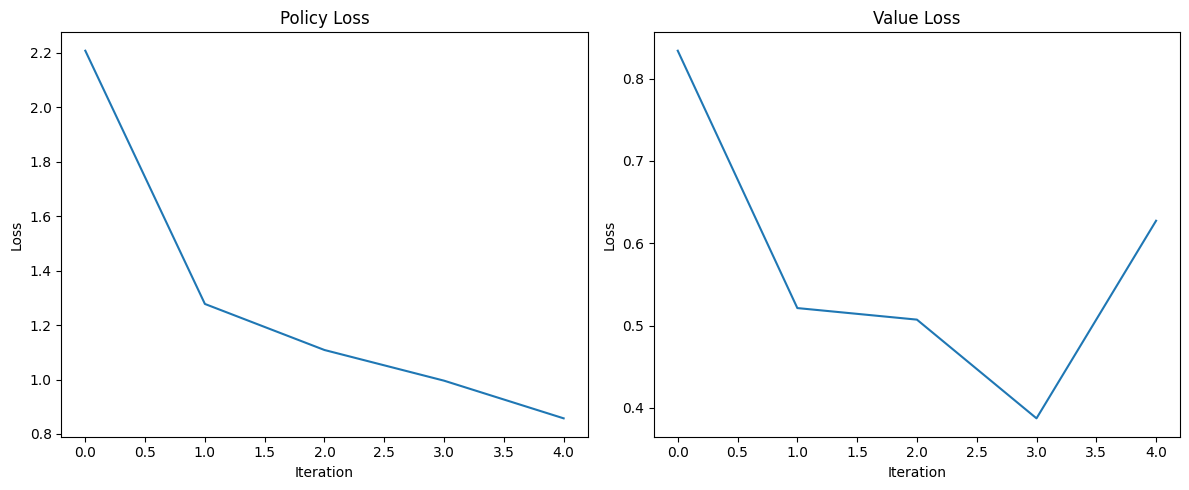

Training completed!


In [ ]:
# Usage
if __name__ == "__main__":
    # Create model
    model = CheckersCNN()

    # Create trainer
    trainer = AlphaZeroTrainer(model, lr=0.001)

    # Train
    policy_losses, value_losses = trainer.train(
        iterations=5,
        games_per_iteration=2,
        train_steps_per_iteration=10
    )

    print("Training completed!")

In [ ]:
if __name__ == "__main__":
    model = CheckersCNN()
    # Provide path to your saved checkpoint here
    checkpoint_path = "checkers_model_5.pth"  # <-- change this to your file
    trainer = AlphaZeroTrainer(model, lr=0.001, checkpoint=checkpoint_path)

    # Continue training
    policy_losses, value_losses = trainer.train(
        iterations=5,
        games_per_iteration=10,
        train_steps_per_iteration=10
    )

In [ ]:
def test_node_class():
    import numpy as np

    # --- Initialize game ---
    game = Checkers()
    game.set_initial_state()

    # --- Node arguments ---
    args = {"C": 1.4, "num_searches": 0}  # num_searches not used here

    # --- Create root node ---
    root_state = game.board.copy()
    root_node = Node(game, args, root_state)

    print("Root expandable moves:", root_node.expandable_moves)

    # --- Expand first 3 moves ---
    for _ in range(min(3, len(root_node.expandable_moves))):
        child = root_node.expand()
        print("Expanded action:", child.action_taken)
        print("Child board state:\n", child.state)

        # --- Simulate from child ---
        value = child.simulate()
        print("Simulation value from child:", value)

        # --- Backpropagate value ---
        child.backpropagate(value)
        print("After backpropagate: root visit count =", root_node.visit_count)
        print("Root value sum =", root_node.value_sum)
        print("-----")

    print("Final root node children count:", len(root_node.children))
    for c in root_node.children:
        print("Child action:", c.action_taken, "Visit count:", c.visit_count, "Value sum:", c.value_sum)

# Run the test
test_node_class()


NameError: name 'Checkers' is not defined

In [ ]:
import numpy as np
from collections import defaultdict
import math

def test_mcts_with_checkers():
    # --- Create game instance ---
    game = Checkers()
    game.set_initial_state()

    # --- MCTS arguments ---
    args = {
        "num_searches": 20,  # number of simulations
        "C": 1.4             # exploration constant
    }

    # --- Initialize MCTS ---
    mcts = MCTS(game, args)

    # --- Run search ---
    state = game.board.copy()
    action_probs = mcts.search(state)

    # --- Print results ---
    print("Action probabilities from MCTS search:")
    for action, prob in action_probs.items():
        print(f"Move {action}: {prob:.3f}")

# Run the test
test_mcts_with_checkers()


Action probabilities from MCTS search:
Move ((2, 7), 0): 0.150
Move ((2, 5), 1): 0.150
Move ((2, 5), 0): 0.150
Move ((2, 3), 1): 0.150
Move ((2, 3), 0): 0.150
Move ((2, 1), 1): 0.150
Move ((2, 1), 0): 0.100


In [ ]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken

        self.children = []
        self.expandable_moves =list(self.game.get_moves(self.game.get_valid_moves(self.state)))

        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.expandable_moves) == 0 and len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        q_value = child.value_sum / (child.visit_count + 1e-6)  # avoid div by zero
        return q_value + self.args["C"] * math.sqrt(
            math.log(self.visit_count + 1) / (child.visit_count + 1e-6)
        )



    def expand(self):
        if not self.expandable_moves:
            return self

        action = self.expandable_moves.pop()
        child_state = self.state.copy()
        self.game.board = child_state.copy()  # sync
        child_state = self.game.apply_move(action)

        child_state = self.game.get_opponent()  # switch perspective
        child = Node(self.game, self.args, child_state, self, action)
        self.children.append(child)
        return child

    def simulate(self):
    # Check terminal state
     if self.game.EndGame() != 0:
         return self.game.EndGame()

     rollout_player = 1
     max_steps = 100  # prevent infinite loops
     for _ in range(max_steps):
        moves = self.game.get_moves(self.game.get_valid_moves(self.game.board))
        if not moves:
            return -1 if rollout_player == 1 else 1  # no moves -> lose

        action = moves[np.random.randint(len(moves))]
        self.game.apply_move(action )  # apply move for correct player

        result = self.game.EndGame()
        if result != 0:
            return result

        self.game.board = self.game.get_opponent()  # flip board for next player
        rollout_player *= -1

    # if max steps exceeded, return draw
     return 0

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(-value)


class MCTS:
    def __init__(self, game, args):
        self.game = game
        self.args = args

    def search(self, state):
        root = Node(self.game, self.args, state)

        for _ in range(self.args["num_searches"]):
            node = root

            # Selection
            while node.is_fully_expanded():
                node = node.select()

            # Expansion
            result = self.game.EndGame()
            if result == 0:  # not terminal
                node = node.expand()
                value = node.simulate()
            else:
                value = result

            # Backpropagation
            node.backpropagate(value)

        # Convert visit counts to probabilities
        action_probs = defaultdict(float)
        total_visits = sum(child.visit_count for child in root.children)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count / total_visits

        return action_probs



In [ ]:
import torch

def mask_illegal_moves(policy, available_moves):


    mask = torch.zeros_like(policy[0])

    for (i,j), moves in available_moves.items():
        for direction, valid in enumerate(moves):
            if valid:
                index = (i*8 + j)*4 + direction
                mask[index] = 1

    masked_policy = policy * mask


    if masked_policy.sum() > 0:
        masked_policy = masked_policy / masked_policy.sum()

    return masked_policy

In [ ]:
def apply_policy_to_state(state, policy, available_moves):
    """
    Apply a policy to a board state to get the next state.
    """
    masked_policy = mask_illegal_moves(policy, available_moves)

    masked_policy_np = masked_policy.detach().cpu().numpy().flatten()

    # Ensure all probabilities are non-negative
    masked_policy_np = np.clip(masked_policy_np, 0, None)

    # If sum is zero (no legal moves), return current state
    total = masked_policy_np.sum()
    if total == 0:
        print("No legal moves available")
        return state
    masked_policy_np /= total  # normalize

    # Sample action
    action_index = np.random.choice(len(masked_policy_np), p=masked_policy_np)

    # Decode action_index to (i, j, direction)
    i = action_index // 32
    j = (action_index % 32) // 4
    direction = action_index % 4
    action = ((i, j), direction)

    # Apply move (assuming you have a self-contained apply_move)
    next_state = state.copy()
    next_state = game.apply_move(  action )  # adjust player if needed

    return next_state



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Two 3x3 convolutions inside residual block
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(x + out)  # Residual connection
        return out

class CheckersCNN(nn.Module):
    def __init__(self, num_res_blocks=4, board_channels=5, torso_channels=256, policy_size=512):
        super().__init__()
        # Initial conv layer (like AlphaZero)
        self.conv_in = nn.Conv2d(board_channels, torso_channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(torso_channels)

        # Residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(torso_channels) for _ in range(num_res_blocks)])

        # Policy head
        self.policy_conv = nn.Conv2d(torso_channels, 2, kernel_size=1)  # reduce channels to 2
        self.policy_bn = nn.BatchNorm2d(2)
        self.policy_fc = nn.Linear(2*8*8, policy_size)  # flatten 8x8x2 → FC
        # Policy output will be logits of size `policy_size`

        # Value head
        self.value_conv = nn.Conv2d(torso_channels, 1, kernel_size=1)  # reduce channels to 1
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(8*8*1, 64)
        self.value_fc2 = nn.Linear(64, 1)  # tanh output [-1,1]

    def forward(self, x):
        # Input conv
        x = F.relu(self.bn_in(self.conv_in(x)))

        # Residual torso
        for block in self.res_blocks:
            x = block(x)

        # Policy head
        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = p.view(p.size(0), -1)
        p = self.policy_fc(p)  # raw logits

        # Value head
        v = F.relu(self.value_bn(self.value_conv(x)))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))  # output between -1 and 1

        return p, v

In [ ]:
import torch
import numpy as np
from collections import defaultdict

# --------------------------
# Board to tensor function
# --------------------------
def board_to_tensor(board, current_player=1):
    planes = np.zeros((5, 8, 8), dtype=np.float32)
    planes[0] = (board == 1).astype(np.float32)   # White pieces
    planes[1] = (board == 2).astype(np.float32)   # White kings
    planes[2] = (board == -1).astype(np.float32)  # Black pieces
    planes[3] = (board == -2).astype(np.float32)  # Black kings
    planes[4] = np.ones((8, 8), dtype=np.float32) * current_player
    return planes
def Possible_cap_b(board, i, j, player):
    """Return possible capture moves for a piece at (i,j)"""
    d = defaultdict(lambda: np.zeros(4))
    n = 8

    if player == -1:  # Black pieces
        if board[i][j] <= 0:
            # Forward left
            if i-2 >= 0 and j-2 >= 0 and board[i-2][j-2] == 0:
                if board[i-1][j-1] != 0 and board[i-1][j-1] >= 1:
                    d[i, j][0] = 1
            # Forward right
            if i-2 >= 0 and j+2 < n and board[i-2][j+2] == 0:
                if board[i-1][j+1] != 0 and board[i-1][j+1] >= 1:
                    d[i, j][1] = 1
        if board[i][j] < 0:  # King moves
            # Backward left
            if i+2 < n and j-2 >= 0 and board[i+2][j-2] == 0:
                if board[i+1][j-1] != 0 and board[i+1][j-1] >= 1:
                    d[i, j][2] = 1
            # Backward right
            if i+2 < n and j+2 < n and board[i+2][j+2] == 0:
                if board[i+1][j+1] != 0 and board[i+1][j+1] >= 1:
                    d[i, j][3] = 1

    if player == 1:  # White pieces
        if board[i][j] >= 1:
            # Forward left
            if i+2 < n and j-2 >= 0 and board[i+2][j-2] == 0:
                if board[i+1][j-1] != 0 and board[i+1][j-1] <= 0:
                    d[i, j][0] = 1
            # Forward right
            if i+2 < n and j+2 < n and board[i+2][j+2] == 0:
                if board[i+1][j+1] != 0 and board[i+1][j+1] <= 0:
                    d[i, j][1] = 1
        if board[i][j] > 1:  # King moves
            # Backward left
            if i-2 >= 0 and j-2 >= 0 and board[i-2][j-2] == 0:
                if board[i-1][j-1] != 0 and board[i-1][j-1] <= 0:
                    d[i, j][2] = 1
            # Backward right
            if i-2 >= 0 and j+2 < n and board[i-2][j+2] == 0:
                if board[i-1][j+1] != 0 and board[i-1][j+1] <= 0:
                    d[i, j][3] = 1

    # Convert d dictionary to move list
    move_list = []
    for pos, arr in d.items():
        for idx, val in enumerate(arr):
            if val == 1:
                move_list.append((pos, idx))
    return move_list



def apply_move_b(board, action, player):
    i, j = action[0]
    move = action[1]
    n = 8  # board size

    # Forward-left
    if move == 0:
        if board[i-1][j-1] == 0:
            board[i-1][j-1] = board[i][j]
            board[i][j] = 0
            if i-1 == 0 and board[i-1][j-1] == -1:
                board[i-1][j-1] -= 1  # Promote to king
        else:
            captured_piece = board[i-1][j-1]
            board[i-1][j-1] = 0
            board[i-2][j-2] = board[i][j]
            board[i][j] = 0
            if i-2 == 0 and board[i-2][j-2] == -1:
                board[i-2][j-2] -= 1
            act = Possible_cap_b(board, i-2, j-2, player)
            if act:
                for mv in act:
                    return apply_move_b(board, mv, player)

    # Forward-right
    elif move == 1:
        if board[i-1][j+1] == 0:
            board[i-1][j+1] = board[i][j]
            board[i][j] = 0
            if i-1 == 0 and board[i-1][j+1] == -1:
                board[i-1][j+1] -= 1
        else:
            captured_piece = board[i-1][j+1]
            board[i-1][j+1] = 0
            board[i-2][j+2] = board[i][j]
            board[i][j] = 0
            if i-2 == 0 and board[i-2][j+2] == -1:
                board[i-2][j+2] -= 1
            act = Possible_cap_b(board, i-2, j+2, player)
            if act:
                for mv in act:
                    return apply_move_b(board, mv, player)

    # Backward-left
    elif move == 2:
        if board[i+1][j-1] == 0:
            board[i+1][j-1] = board[i][j]
            board[i][j] = 0
        else:
            captured_piece = board[i+1][j-1]
            board[i+1][j-1] = 0
            board[i+2][j-2] = board[i][j]
            board[i][j] = 0
            act = Possible_cap_b(board, i+2, j-2, player)
            if act:
                for mv in act:
                    return apply_move_b(board, mv, player)

    # Backward-right
    elif move == 3:
        if board[i+1][j+1] == 0:
            board[i+1][j+1] = board[i][j]
            board[i][j] = 0
        else:
            captured_piece = board[i+1][j+1]
            board[i+1][j+1] = 0
            board[i+2][j+2] = board[i][j]
            board[i][j] = 0
            act = Possible_cap_b(board, i+2, j+2, player)
            if act:
                for mv in act:
                    return apply_move_b(board, mv, player)

    return board

def play_against_agent(model, device="cuda"):
    game = FixedCheckers()
    game.current_player = -1  # Human starts at top

    while True:
        print("\nCurrent Board:")
        print(game.board)

        # Check if game ended
        result = game.EndGame()
        if result != 0:
            if result == 1:
                print("White (Agent) wins!")
            elif result == -1:
                print("Black (Human) wins!")
            else:
                print("Draw / No moves left!")
            break

        # Human turn (-1)
        if game.current_player == -1:
            moves = game.get_moves(game.get_valid_moves())
            if not moves:
                print("No moves available for Human! You lose.")
                break

            print("\nYour possible moves (Black = -1):")
            for idx, mv in enumerate(moves):
                print(f"{idx}: {mv}")

            try:
                choice = int(input("Select move index: "))
                action = moves[choice]
            except:
                print("Invalid input! Picking first available move.")
                action = moves[0]

            apply_move_b(game.board, action,-1)
            game.switch_player()

        # Agent turn (1)
        else:
            moves = game.get_moves(game.get_valid_moves())
            if not moves:
                print("No moves available for Agent! You win.")
                break

            state = game.board_to_tensor()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                policy, value = model(state)

            policy = torch.softmax(policy[0], dim=0).cpu().numpy()

            # Pick the best move from policy
            move_idx = np.argmax(policy[:len(moves)])
            action = moves[move_idx]

            print("\nAgent chooses move:", action)
            game.apply_move(action)
            game.switch_player()


# --------------------------
# Usage
# --------------------------
if __name__ == "__main__":
    # Import your CNN model definition here
    # from your_model_file import CheckersCNN, FixedCheckers
    model = CheckersCNN()  # your model class
    device = torch.device("cuda")
    model.load_state_dict(torch.load("/content/checkers_model_300.pth", map_location=device))
    model.to(device)
    model.eval()

    play_against_agent(model, device)



Current Board:
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]

Your possible moves (Black = -1):
0: ((5, 0), 1)
1: ((5, 2), 0)
2: ((5, 2), 1)
3: ((5, 4), 0)
4: ((5, 4), 1)
5: ((5, 6), 0)
6: ((5, 6), 1)
Select move index: 0

Current Board:
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]

Agent chooses move: ((2, 5), 1)

Current Board:
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  1  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]

Your possible moves (Black = -1):
0: ((4, 1), 0)
1: ((4, 1), 1)
2: ((5, 2), 1)
3: ((5, 4), 0)
4: ((5, 4), 

In [ ]:
import numpy as np
from collections import defaultdict

# Assuming FixedCheckers class is already defined above

# Your test board
B = np.array([[ 0, 0,  0 , 0 , 0,  0 , 0 , 0],
             [ 0 ,0 , 0 ,  0,  0 , 0 , 0 , 0],
             [ 0 , 0 , 0,  0 ,  0 , 0,  0 , 2],
             [ 0  ,0 , -1 , 0,  0,  0 ,-1,  0],
             [ 0 ,-1,  0 , 0 , 0 , 0,  0 , 0],
             [-1 , 0 , 0,  0,  1,  0 , 1 , 0],
             [ 0 , 0,  0 , 0,  0, -1 , 0 , -1],
             [ 0 , 0 ,2 , 0, -1 , 0 , 0,  0]])

# Initialize game
game = FixedCheckers()
game.board = B.copy()
game.current_player = 1  # White to move

print("Initial board:")
print(game.board)

print(game.available(1 ))
new_board = game.apply_move(((5,6),1))

print("\nBoard after move:")
print(new_board)

# Check for further captures (double jumps)
caps = game.Possible_cap(4,5, game.current_player)  # final pos after first capture
print("\nPossible additional captures from (4,5):", caps)


Initial board:
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2]
 [ 0  0 -1  0  0  0 -1  0]
 [ 0 -1  0  0  0  0  0  0]
 [-1  0  0  0  1  0  1  0]
 [ 0  0  0  0  0 -1  0 -1]
 [ 0  0  2  0 -1  0  0  0]]
defaultdict(<function FixedCheckers.available.<locals>.<lambda> at 0x7f73664677e0>, {(2, 7): array([1., 0., 1., 0.]), (5, 4): array([1., 1., 0., 0.]), (7, 2): array([0., 0., 1., 1.])})
((5, 6), 1)


IndexError: index 8 is out of bounds for axis 0 with size 8

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from tqdm import tqdm

# Fix the missing board_to_tensor function
def board_to_tensor(board, current_player=1):
    """Convert board to 5-plane tensor representation"""
    planes = np.zeros((5, 8, 8), dtype=np.float32)
    planes[0] = (board == 1).astype(np.float32)   # White pieces
    planes[1] = (board == 2).astype(np.float32)   # White kings
    planes[2] = (board == -1).astype(np.float32)  # Black pieces
    planes[3] = (board == -2).astype(np.float32)  # Black kings
    planes[4] = np.ones((8, 8), dtype=np.float32) * current_player  # Current player
    return planes

class FixedCheckers:
    """Fixed version of your Checkers class"""
    def __init__(self):
        self.board = np.array([
            [0,   1, 0,   1, 0,  1, 0,  1],
            [ 1,  0,  1,  0,  1,  0, 1,  0],
            [0,  1, 0,  1, 0,  1, 0,   1],
            [0,  0, 0,  0, 0,  0, 0,  0],
            [0,  0, 0,  0, 0,  0, 0,  0],
            [-1, 0,  -1, 0,  -1, 0,  -1, 0],
            [0,  -1, 0,  -1, 0,  -1, 0,  -1],
            [ -1, 0,  -1, 0, -1, 0,  -1, 0]
        ], dtype=int)
        self.current_player = 1

    def board_to_tensor(self):
        """Always return board from current player's perspective"""
        if self.current_player == 1:
            return board_to_tensor(self.board, 1)
        else:
            # Flip board so black player sees it from their perspective
            flipped_board = np.flipud(np.fliplr(-self.board))
            return board_to_tensor(flipped_board, 1)

    def copy(self):
        """Create a copy of the game state"""
        new_game = FixedCheckers()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def get_valid_moves(self, player=None):
        """Get valid moves for current player"""
        if player is None:
            player = self.current_player
        return self.available(player)

    def available(self, player=1):
        d = defaultdict(lambda: np.zeros(4))



        if player == 1:  # white pieces
            for i in range(len(self.board)):
                for j in range(len(self.board)):
                    if self.board[i][j] != 0 and self.board[i][j] >= player:
                        # Forward left
                        if i+1 < 8 and j-1 >= 0:
                            if self.board[i+1][j-1] == 0:
                                d[i, j][0] = 1
                            elif self.board[i+1][j-1] <  0:
                                if i+2 < 8 and j-2 >= 0 and self.board[i+2][j-2] == 0:
                                    d[i, j][0] = 1

                        if i+1 < 8 and j+1 < 8:
                            if self.board[i+1][j+1] == 0:
                                d[i, j][1] = 1
                            elif self.board[i+1][j+1] <  0:
                                if i+2 < 8 and j+2 < = 7 and self.board[i+2][j+2] == 0:
                                    d[i,j][1] = 1

                    if self.board[i][j] != 0 and self.board[i][j] > player:
                        # Backward left
                        if i-1 >= 0 and j-1 >= 0:
                            if self.board[i-1][j-1] == 0:
                                d[i, j][2] = 1
                            elif self.board[i-1][j-1]  < 0:
                                if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                                    d[i, j][2] = 1
                        # Backward right
                        if i-1 >= 0 and j+1 < 8:
                            if self.board[i-1][j+1] == 0:
                                d[i, j][3] = 1
                            elif self.board[i-1][j+1]  < 0:
                                if i-2 >= 0 and j+2 < 8 and self.board[i-2][j+2] == 0:
                                    d[i, j][3] = 1
        return d


    def apply_move(self, action, player=1):
     print(action)
     i, j = action[0]
     move = action[1]

     if player == 1:  # White player
        if move == 0:  # forward-left
            if self.board[i+1][j-1] == 0:
                self.board[i+1][j-1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j-1] == 1:
                    self.board[i+1][j-1] += 1

            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j-1]

                self.board[i+1][j-1] = 0
                self.board[i+2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j-2] == 1:
                    self.board[i+2][j-2] += 1

                act = self.Possible_cap(i+2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 1:  # forward-right
            if self.board[i+1][j+1] == 0:
                self.board[i+1][j+1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j+1] == 1:
                    self.board[i+1][j+1] += 1
                    # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j+1]
                   # Remove from black's score

                self.board[i+1][j+1] = 0
                self.board[i+2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j+2] == 1:
                    self.board[i+2][j+2] += 1

                act = self.Possible_cap(i+2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 2:  # backward-left
            if self.board[i-1][j-1] == 0:
                self.board[i-1][j-1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j-1]


                self.board[i-1][j-1] = 0
                self.board[i-2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 3:  # backward-right
            if self.board[i-1][j+1] == 0:
                self.board[i-1][j+1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j+1]


                self.board[i-1][j+1] = 0
                self.board[i-2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

     return self.board

    def Possible_cap(self, i, j, player=1):
     d   = defaultdict(lambda: np.zeros(4))
     n = 8

     if self.board[i][j] >= 1:
            # Forward left
            if i+2 < n and j-2 >= 0 and self.board[i+2][j-2] == 0:
                if self.board[i+1][j-1] != 0 and self.board[i+1][j-1] <= 0:
                    d[i, j][0] = 1
            # Forward right
            if i+2 < n and j+2 < n and self.board[i+2][j+2] == 0:
                if self.board[i+1][j+1] != 0 and self.board[i+1][j+1] <= 0:
                    d[i, j][1] = 1
     if self.board[i][j] > 1:

            if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                if self.board[i-1][j-1] != 0 and self.board[i-1][j-1] <= 0:
                    d[i, j][2] = 1
            # Backward right
            if i-2 >= 0 and j+2 < n and self.board[i-2][j+2] == 0:
                if self.board[i-1][j+1] != 0 and self.board[i-1][j+1] <= 0:
                    d[i, j][3] = 1

     return self.get_moves(d)






     return self.get_moves(d)

    def get_moves(self, d):
        """Convert move dict to list"""
        move_list = []
        for pos, arr in d.items():
            for i, val in enumerate(arr):
                if val == 1:
                    move_list.append((pos, i))
        return move_list

    def switch_player(self):
        """Explicitly switch the current player"""
        self.current_player *= -1

    def EndGame(self):
        """Check if game has ended"""
        white_pieces = np.sum(self.board > 0)
        black_pieces = np.sum(self.board < 0)

        if white_pieces == 0:
            return -1  # Black wins
        elif black_pieces == 0:
            return 1   # White wins

        # Check if current player has moves
        moves = self.get_moves(self.get_valid_moves(self.current_player))
        if not moves:
            return -self.current_player  # Current player loses

        return 0  # Game continues

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(x + out)
        return out

class CheckersCNN(nn.Module):
    def __init__(self, num_res_blocks=4, board_channels=5, torso_channels=128):
        super().__init__()
        # Initial conv layer
        self.conv_in = nn.Conv2d(board_channels, torso_channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(torso_channels)

        # Residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(torso_channels) for _ in range(num_res_blocks)])

        # Policy head (256 possible moves: 64 squares * 4 directions)
        self.policy_conv = nn.Conv2d(torso_channels, 2, kernel_size=1)
        self.policy_bn = nn.BatchNorm2d(2)
        self.policy_fc = nn.Linear(2*8*8, 256)

        # Value head
        self.value_conv = nn.Conv2d(torso_channels, 1, kernel_size=1)
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(8*8, 64)
        self.value_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Input conv
        x = F.relu(self.bn_in(self.conv_in(x)))

        # Residual torso
        for block in self.res_blocks:
            x = block(x)

        # Policy head
        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = p.view(p.size(0), -1)
        p = self.policy_fc(p)

        # Value head
        v = F.relu(self.value_bn(self.value_conv(x)))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))

        return p, v

class Node:
    def __init__(self, game_state, parent=None, action_taken=None, prior=0):
        self.game_state = game_state.copy()
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.is_expanded = False

    def is_terminal(self):
        return self.game_state.EndGame() != 0

    def expand(self, policy):
        """Expand node with policy from neural network"""
        if self.is_expanded:
            return

        moves_dict = self.game_state.get_valid_moves()
        moves = self.game_state.get_moves(moves_dict)

        if not moves:
            self.is_expanded = True
            return

        # Convert moves to policy indices
        policy_probs = F.softmax(policy, dim=0)

        for move in moves:
            (i, j), direction = move
            policy_idx = i * 32 + j * 4 + direction
            prior = policy_probs[policy_idx].item()

            new_game = self.game_state.copy()
            new_game.apply_move(move)
            new_game.switch_player()  # Explicitly switch player

            child = Node(new_game, parent=self, action_taken=move, prior=prior)
            self.children[move] = child

        self.is_expanded = True

    def select_child(self, c_puct=1.0):
        """Select child with highest UCB score"""
        best_score = -float('inf')
        best_child = None

        for child in self.children.values():
            q_value = 0 if child.visit_count == 0 else child.value_sum / child.visit_count
            u_value = c_puct * child.prior * math.sqrt(self.visit_count) / (1 + child.visit_count)
            score = q_value + u_value

            if score > best_score:
                best_score = score
                best_child = child

        return best_child

    def backup(self, value):
        """Backup value through the tree"""
        self.visit_count += 1
        self.value_sum += value

        if self.parent:
            self.parent.backup(-value)

class MCTS:
    def __init__(self, model, device, c_puct=1.0):
        self.model = model
        self.device = device
        self.c_puct = c_puct

    def search(self, game_state, num_simulations=100):
        """Run MCTS search"""
        root = Node(game_state)

        for _ in range(num_simulations):
            node = root

            # Selection
            while node.is_expanded and not node.is_terminal():
                node = node.select_child(self.c_puct)

            # Evaluation
            if node.is_terminal():
                value = node.game_state.EndGame()
            else:
                # Get neural network prediction
                board_tensor = torch.tensor(node.game_state.board_to_tensor(), dtype=torch.float32).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    policy, value = self.model(board_tensor)
                    value = value.item()

                # Expansion
                node.expand(policy.squeeze(0))

            # Backup
            node.backup(value)

        # Return visit count distribution as policy
        moves_dict = game_state.get_valid_moves()
        moves = game_state.get_moves(moves_dict)

        policy = np.zeros(256)
        for move in moves:
            if move in root.children:
                (i, j), direction = move
                policy_idx = i * 32 + j * 4 + direction
                policy[policy_idx] = root.children[move].visit_count

        if policy.sum() > 0:
            policy = policy / policy.sum()

        return policy, root.value_sum / max(root.visit_count, 1)

class AlphaZeroTrainer:
    def __init__(self, model, lr=0.001):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.mcts = MCTS(self.model, self.device)

        self.training_data = deque(maxlen=10000)

    def self_play(self, num_simulations=25):
        """Play one self-play game with consistent perspective"""
        game = FixedCheckers()
        training_examples = []
        move_count = 0

        while move_count < 200:  # Prevent infinite games
            move_count += 1

            # Get MCTS policy (always from current player's perspective)
            policy, _ = self.mcts.search(game, num_simulations)

            # Store training example (always from player 1's perspective due to board_to_tensor)
            board_tensor = game.board_to_tensor()
            training_examples.append((board_tensor, policy, None, game.current_player))

            # Sample action from policy
            valid_indices = []
            valid_probs = []
            moves_dict = game.get_valid_moves()
            moves = game.get_moves(moves_dict)

            for move in moves:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                if policy[idx] > 0:
                    valid_indices.append(idx)
                    valid_probs.append(policy[idx])

            if not valid_indices:
                break

            valid_probs = np.array(valid_probs)
            valid_probs = valid_probs / valid_probs.sum()

            chosen_idx = np.random.choice(len(valid_indices), p=valid_probs)
            policy_idx = valid_indices[chosen_idx]

            # Convert back to move
            i = policy_idx // 32
            j = (policy_idx % 32) // 4
            direction = policy_idx % 4
            action = ((i, j), direction)
            # Apply move and switch players
            game.apply_move(action)
            game.switch_player()

            # Check if game ended
            result = game.EndGame()
            if result != 0:
                # Fill in values for training examples
                for idx, (board, pol, _, player_who_moved) in enumerate(training_examples):
                    # Value from perspective of the player who made the move
                    if player_who_moved == result:
                        value = 1.0  # Win
                    elif player_who_moved == -result:
                        value = -1.0  # Loss
                    else:
                        value = 0.0  # Draw

                    training_examples[idx] = (board, pol, value)

                break

        # Filter out the player information and return clean training examples
        clean_examples = []
        for example in training_examples:
            if len(example) == 3:  # Already processed (board, policy, value)
                board, policy, value = example
                if value is not None:
                    clean_examples.append((board, policy, value))
            elif len(example) == 4:  # Not yet processed (board, policy, None, player)
                # This shouldn't happen if the loop above worked correctly
                continue

        return clean_examples

    def train_step(self, batch_size=32):
        """Train the model on a batch of data"""
        if len(self.training_data) < batch_size:
            return 0, 0

        # Sample batch
        batch = random.sample(list(self.training_data), batch_size)

        boards = torch.tensor([x[0] for x in batch], dtype=torch.float32).to(self.device)
        target_policies = torch.tensor([x[1] for x in batch], dtype=torch.float32).to(self.device)
        target_values = torch.tensor([[x[2]] for x in batch], dtype=torch.float32).to(self.device)

        # Forward pass
        pred_policies, pred_values = self.model(boards)

        # Calculate losses
        policy_loss = F.cross_entropy(pred_policies, target_policies)
        value_loss = F.mse_loss(pred_values, target_values)
        total_loss = policy_loss + value_loss

        # Backward pass
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        return policy_loss.item(), value_loss.item()

    def train(self, iterations=1000, games_per_iteration=10, train_steps_per_iteration=10):
        """Main training loop"""
        print(f"Training on device: {self.device}")

        policy_losses = []
        value_losses = []

        for iteration in tqdm(range(iterations)):
            # Self-play games
            for _ in range(games_per_iteration):
                examples = self.self_play()
                self.training_data.extend(examples)

            # Training steps
            total_policy_loss = 0
            total_value_loss = 0

            for _ in range(train_steps_per_iteration):
                p_loss, v_loss = self.train_step()
                total_policy_loss += p_loss
                total_value_loss += v_loss

            avg_policy_loss = total_policy_loss / train_steps_per_iteration
            avg_value_loss = total_value_loss / train_steps_per_iteration

            policy_losses.append(avg_policy_loss)
            value_losses.append(avg_value_loss)

            if iteration % 1 == 0:
                print(f"Iteration {iteration}: Policy Loss: {avg_policy_loss:.4f}, Value Loss: {avg_value_loss:.4f}")
                print(f"Training data size: {len(self.training_data)}")

                # Save checkpoint
                torch.save(self.model.state_dict(), f'checkers_model_{iteration}.pth')

        # Plot training progress
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(policy_losses)
        ax1.set_title('Policy Loss')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')

        ax2.plot(value_losses)
        ax2.set_title('Value Loss')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Loss')

        plt.tight_layout()
        plt.show()

        # Save final model
        torch.save(self.model.state_dict(), 'checkers_final_model.pth')

        return policy_losses, value_losses





In [ ]:
# Usage
if __name__ == "__main__":
    # Create model
    model = CheckersCNN()

    # Create trainer
    trainer = AlphaZeroTrainer(model, lr=0.001)

    # Train
    policy_losses, value_losses = trainer.train(
        iterations=5,
        games_per_iteration=10,
        train_steps_per_iteration=10
    )

    print("Training completed!")

Training on device: cpu


  0%|          | 0/5 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
import numpy as np
import random

class Checkers:
    def __init__(self):
        self.board = np.zeros((8, 8), dtype=int)

        # Place Black (-1) at TOP
        for i in range(3):
            for j in range(8):
                if (i + j) % 2 == 1:
                    self.board[i, j] = -1

        # Place White (+1) at BOTTOM
        for i in range(5, 8):
            for j in range(8):
                if (i + j) % 2 == 1:
                    self.board[i, j] = +1

        self.current_player = -1  # Human starts

        # Directions: Black goes down, White goes up
        self.DIRECTIONS = {
            -1: {0: (1, -1), 1: (1, +1)},   # Human (Black)
            +1: {0: (-1, -1), 1: (-1, +1)}  # Agent (White)
        }

    def get_legal_moves(self, player):
        moves = []
        for i in range(8):
            for j in range(8):
                if self.board[i, j] == player:
                    for d, (di, dj) in self.DIRECTIONS[player].items():
                        ni, nj = i + di, j + dj
                        if 0 <= ni < 8 and 0 <= nj < 8 and self.board[ni, nj] == 0:
                            moves.append(((i, j), d))
        return moves
    def Possible_cap(self,i, j , player):

     d = defaultdict(lambda: np.zeros(4))
     n = 8

     if player == -1:
        if self.board[i][j] <= 0:
            # Forward left
            if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                if self.board[i-1][j-1] != 0 and self.board[i-1][j-1] >= 1:
                    d[i, j][0] = 1
            # Forward right
            if i-2 >= 0 and j+2 < n and self.board[i-2][j+2] == 0:
                if self.board[i-1][j+1] != 0 and self.board[i-1][j+1] >= 1:
                    d[i, j][1] = 1
        if self.board[i][j] < 0:
            # Backward left
            if i+2 < n and j-2 >= 0 and self.board[i+2][j-2] == 0:
                if self.board[i+1][j-1] != 0 and self.board[i+1][j-1] >= 1:
                    d[i, j][2] = 1
            # Backward right
            if i+2 < n and j+2 < n and self.board[i+2][j+2] == 0:
                if self.board[i+1][j+1] != 0 and self.board[i+1][j+1] >= 1:
                    d[i, j][3] = 1

     if player == 1:  # white pieces
        if self.board[i][j] >= 1:
            # Forward left
            if i+2 < n and j-2 >= 0 and self.board[i+2][j-2] == 0:
                if self.board[i+1][j-1] != 0 and self.board[i+1][j-1] <= 0:
                    d[i, j][0] = 1
            # Forward right
            if i+2 < n and j+2 < n and self.board[i+2][j+2] == 0:
                if self.board[i+1][j+1] != 0 and self.board[i+1][j+1] <= 0:
                    d[i, j][1] = 1
        if self.board[i][j] > 1:

            if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                if self.board[i-1][j-1] != 0 and self.board[i-1][j-1] <= 0:
                    d[i, j][2] = 1
            # Backward right
            if i-2 >= 0 and j+2 < n and self.board[i-2][j+2] == 0:
                if self.board[i-1][j+1] != 0 and self.board[i-1][j+1] <= 0:
                    d[i, j][3] = 1

     return self.get_moves(d)

       def apply_move(self, action, player):
     i, j = action[0]
     move = action[1]

     if player >= 1:  # White player
        if move == 0:  # forward-left
            if self.board[i+1][j-1] == 0:
                self.board[i+1][j-1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j-1] == 1:
                    self.board[i+1][j-1] += 1
                    self.score1 += 1  # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j-1]
                self.score2 -= abs(captured_piece)  # Remove from black's score

                self.board[i+1][j-1] = 0
                self.board[i+2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j-2] == 1:
                    self.board[i+2][j-2] += 1
                    self.score1 += 1  # Extra point for king promotion
                act = self.Possible_cap(i+2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 1:  # forward-right
            if self.board[i+1][j+1] == 0:
                self.board[i+1][j+1] = self.board[i][j]
                self.board[i][j] = 0
                if i+1 == 7 and self.board[i+1][j+1] == 1:
                    self.board[i+1][j+1] += 1
                    self.score1 += 1  # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j+1]
                self.score2 -= abs(captured_piece)  # Remove from black's score

                self.board[i+1][j+1] = 0
                self.board[i+2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                if i+2 == 7 and self.board[i+2][j+2] == 1:
                    self.board[i+2][j+2] += 1
                    self.score1 += 1  # Extra point for king promotion
                act = self.Possible_cap(i+2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 2:  # backward-left
            if self.board[i-1][j-1] == 0:
                self.board[i-1][j-1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j-1]
                self.score2 -= abs(captured_piece)  # Remove from black's score

                self.board[i-1][j-1] = 0
                self.board[i-2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 3:  # backward-right
            if self.board[i-1][j+1] == 0:
                self.board[i-1][j+1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j+1]
                self.score2 -= abs(captured_piece)  # Remove from black's score

                self.board[i-1][j+1] = 0
                self.board[i-2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i-2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

     elif player <= -1:  # Black player
        if move == 0:  # forward-left
            if self.board[i-1][j-1] == 0:
                self.board[i-1][j-1] = self.board[i][j]
                self.board[i][j] = 0
                if i-1 == 0 and self.board[i-1][j-1] == -1:
                    self.board[i-1][j-1] -= 1
                    self.score2 += 1  # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j-1]
                self.score1 -= abs(captured_piece)  # Remove from white's score

                self.board[i-1][j-1] = 0
                self.board[i-2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                if i-2 == 0 and self.board[i-2][j-2] == -1:
                    self.board[i-2][j-2] -= 1
                    self.score2 += 1  # Extra point for king promotion
                act = self.Possible_cap(i-2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 1:  # forward-right
            if self.board[i-1][j+1] == 0:
                self.board[i-1][j+1] = self.board[i][j]
                self.board[i][j] = 0
                if i-1 == 0 and self.board[i-1][j+1] == -1:
                    self.board[i-1][j+1] -= 1
                    self.score2 += 1  # Extra point for king promotion
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i-1][j+1]
                self.score1 -= abs(captured_piece)  # Remove from white's score

                self.board[i-1][j+1] = 0
                self.board[i-2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                if i-2 == 0 and self.board[i-2][j+2] == -1:
                    self.board[i-2][j+2] -= 1
                    self.score2 += 1  # Extra point for king promotion
                act = self.Possible_cap(i-2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 2:  # backward-left
            if self.board[i+1][j-1] == 0:
                self.board[i+1][j-1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j-1]
                self.score1 -= abs(captured_piece)  # Remove from white's score

                self.board[i+1][j-1] = 0
                self.board[i+2][j-2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i+2, j-2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)

        elif move == 3:  # backward-right
            if self.board[i+1][j+1] == 0:
                self.board[i+1][j+1] = self.board[i][j]
                self.board[i][j] = 0
            else:
                # Capture opponent piece - update score
                captured_piece = self.board[i+1][j+1]
                self.score1 -= abs(captured_piece)  # Remove from white's score

                self.board[i+1][j+1] = 0
                self.board[i+2][j+2] = self.board[i][j]
                self.board[i][j] = 0
                act = self.Possible_cap(i+2, j+2, player)
                if act:
                    for mv in act:
                        return self.apply_move(mv, player)


    def switch_player(self):
        self.current_player *= -1

    def play(self):
        print("You are: HUMAN = -1 (Black, top, moves down)")
        print("Agent is: +1 (White, bottom, moves up)")
        print("Enter moves as: row col dir (dir=0 left, dir=1 right)\n")

        while True:
            print("Current board:")
            print(self.board)
            print("Current player:", self.current_player)

            legal = self.get_legal_moves(self.current_player)
            if not legal:
                print("No legal moves! Player", self.current_player, "loses.")
                break

            if self.current_player == -1:  # Human
                try:
                    move_in = input("Your move (i j dir): ")
                    i, j, d = map(int, move_in.split())
                    move = ((i, j), d)
                    if move not in legal:
                        print("Illegal move. Legal moves:", legal[:7], "...")
                        continue
                    self.apply_move(move, -1)
                except Exception as e:
                    print("Bad input:", e)
                    continue
            else:  # Agent
                move = random.choice(legal)
                print("Agent chooses:", move)
                self.apply_move(move, +1)

            self.switch_player()


In [ ]:
game = Checkers()
game.play()


You are: HUMAN = -1 (Black, top, moves down)
Agent is: +1 (White, bottom, moves up)
Enter moves as: row col dir (dir=0 left, dir=1 right)

Current board:
[[ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]]
Current player: -1
Your move (i j dir): 2 1 0
Current board:
[[ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0  0  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]]
Current player: 1
Agent chooses: ((5, 0), 1)
Current board:
[[ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0  0  0 -1  0 -1  0 -1]
 [-1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]]
Current player: -1
Your move (i j dir): 2 3 0
Current board:
[[ 0 -1  0 -1

KeyboardInterrupt: Interrupted by user

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

def play_against_agent(model, device, num_simulations=50):
    game = FixedCheckers()
    mcts = MCTS(model, device)

    current_player = 1

    while True:
        print(f"Player {current_player}'s turn")
        print(game.board)

        # Check if game ended
        result = game.EndGame()
        if result != 0:
            if result == 1:
                print("White wins!")
            else:
                print("Black wins!")
            break

        if current_player == 1:
            # Agent move
            policy, _ = mcts.search(game, num_simulations)
            # Mask invalid moves
            valid_moves_dict = game.get_valid_moves()
            valid_moves = game.get_moves(valid_moves_dict)

            policy_mask = np.zeros_like(policy)
            valid_indices = []
            valid_probs = []
            for move in valid_moves:
                (i, j), direction = move
                idx = i * 32 + j * 4 + direction
                policy_mask[idx] = policy[idx]
                valid_indices.append(idx)
                valid_probs.append(policy[idx])

            if len(valid_indices) == 0:
                print("No valid moves! Player loses.")
                break

            valid_probs = np.array(valid_probs)
            valid_probs = valid_probs / valid_probs.sum()

            chosen_idx = np.random.choice(len(valid_indices), p=valid_probs)
            policy_idx = valid_indices[chosen_idx]

            # Decode back to move
            i = policy_idx // 32
            j = (policy_idx % 32) // 4
            direction = policy_idx % 4
            action = ((i, j), direction)
            print("Agent chooses:", action)

            game.apply_move(action)

        else:
            # Human input
            print("Enter your move as: i j direction (0-3)")
            move_input = input()
            try:
                i, j, direction = map(int, move_input.strip().split())
                action = ((i, j), direction)
                # Validate move
                valid_moves_dict = game.get_valid_moves(current_player)
                valid_moves = game.get_moves(valid_moves_dict)
                if action not in valid_moves:
                    print("Invalid move! Try again.")
                    continue
                game.apply_move(action)
            except:
                print("Invalid input! Try again.")
                continue

        # Switch player
        game.switch_player()
        current_player *= -1



In [ ]:
play_against_agent(model, device, 50)

Player 1's turn
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  1  0  1  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
Agent chooses: ((2, 3), 1)
Player -1's turn
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  0  0  1  0  1]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
Enter your move as: i j direction (0-3)
5 0 1
Player 1's turn
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  0  0  1  0  1]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  0 -1]
 [-1  0 -1  0 -1  0 -1  0]]
Agent chooses: ((2, 7), 0)
Player -1's turn
[[ 0  1  0  1  0  1  0  1]
 [ 1  0  1  0  1  0  1  0]
 [ 0  1  0  0  0  1  0  0]
 [ 0  0  0  0  1  0  1  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1  0]
 [ 0 -1  0 -1  0 -1  

KeyboardInterrupt: Interrupted by user

In [ ]:
model = models.Sequential()

In [ ]:
# Assuming you have a CheckersNet instance
model = CheckersNN( )

# Forward pass
policy, value = model(board_tensor)

print("Policy shape:", policy.shape)  # should be [1, 1024]
print("Value:", value.item())

Policy shape: torch.Size([1, 1024])
Value: -0.00334688788279891


In [ ]:
mask = torch.zeros_like(policy)

In [ ]:
mask.shape

torch.Size([1, 1024])

In [ ]:
available_moves=available(b,1)
mask = torch.zeros_like(policy)
for (i,j), moves in available_moves.items():
        for direction, valid in enumerate(moves):
            if valid:  # legal move
                index = (i*8 + j)*4 + direction
                mask[index] = 1

IndexError: index 33 is out of bounds for dimension 0 with size 1

In [ ]:
a=mask_illegal_moves(policy,available(b,1))

In [ ]:
max_index = torch.argmax(a)
print(max_index)

tensor(40)


In [ ]:
import torch

def mask_illegal_moves(policy, available_moves):
    # policy: tensor shape [1024]
    mask = torch.zeros_like(policy[0])  # all zeros

    for (i,j), moves in available_moves.items():
        for direction, valid in enumerate(moves):
            if valid:  # legal move
                index = (i*8 + j)*4 + direction
                mask[index] = 1  # allow this move

    # Apply mask: illegal moves become 0
    masked_policy = policy * mask

    # Re-normalize to sum to 1
    if masked_policy.sum() > 0:
        masked_policy = masked_policy / masked_policy.sum()

    return masked_policy


In [ ]:
policy

tensor([[0.0010, 0.0010, 0.0009,  ..., 0.0010, 0.0010, 0.0010]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
game = CheckersNN()
game.board = b

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CheckersNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Shared convolutional body
        self.conv1 = nn.Conv2d(6, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        # Policy head
        self.policy_conv = nn.Conv2d(128, 64, 1)
        self.policy_fc = nn.Linear(64*8*8, 1024)

        # Value head
        self.value_conv = nn.Conv2d(128, 64, 1)
        self.value_fc1 = nn.Linear(64*8*8, 64)
        self.value_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Shared body
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Policy head
        p = F.relu(self.policy_conv(x))
        p = p.view(p.size(0), -1)
        p = self.policy_fc(p)

        # Value head
        v = F.relu(self.value_conv(x))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))

        return p, v

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Two 3x3 convolutions inside residual block
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(x + out)  # Residual connection
        return out

class CheckersCNN(nn.Module):
    def __init__(self, num_res_blocks=20, board_channels=6, torso_channels=256, policy_size=512):
        super().__init__()
        # Initial conv layer (like AlphaZero)
        self.conv_in = nn.Conv2d(board_channels, torso_channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm2d(torso_channels)

        # Residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(torso_channels) for _ in range(num_res_blocks)])

        # Policy head
        self.policy_conv = nn.Conv2d(torso_channels, 2, kernel_size=1)  # reduce channels to 2
        self.policy_bn = nn.BatchNorm2d(2)
        self.policy_fc = nn.Linear(2*8*8, policy_size)  # flatten 8x8x2 → FC
        # Policy output will be logits of size `policy_size`

        # Value head
        self.value_conv = nn.Conv2d(torso_channels, 1, kernel_size=1)  # reduce channels to 1
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(8*8*1, 64)
        self.value_fc2 = nn.Linear(64, 1)  # tanh output [-1,1]

    def forward(self, x):
        # Input conv
        x = F.relu(self.bn_in(self.conv_in(x)))

        # Residual torso
        for block in self.res_blocks:
            x = block(x)

        # Policy head
        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = p.view(p.size(0), -1)
        p = self.policy_fc(p)  # raw logits

        # Value head
        v = F.relu(self.value_bn(self.value_conv(x)))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))  # output between -1 and 1

        return p, v

In [ ]:


import torch

def ucb_scores(Q, N, P, c):
    """
    Compute U(s,a) for all actions from a state.

    Q: tensor [num_actions] - action value estimates
    N: tensor [num_actions] - visit counts for each action
    P: tensor [num_actions] - NN priors for each action
    c: float - exploration constant
    """
    total_N = torch.sum(N)  # ∑b N(s,b)
    u = Q + c * P * (torch.sqrt(total_N + 1e-8) / (1 + N))
    return u

In [ ]:
# Example with 4 actions
Q = torch.tensor([0.2, 0.5, 0.0, -0.1], dtype=torch.float32)
N = torch.tensor([10, 30, 5, 0], dtype=torch.float32)
P = torch.tensor([0.25, 0.25, 0.25, 0.25], dtype=torch.float32)  # uniform prior
c = 1.5

U = ucb_scores(Q, N, P, c)
print("U(s,a):", U)

# Pick best action
best_action = torch.argmax(U).item()
print("Chosen action index:", best_action)


U(s,a): tensor([0.4287, 0.5811, 0.4193, 2.4156])
Chosen action index: 3


In [ ]:
import torch
import torch.nn.functional as F

class Node:
    def __init__(self, state, player, prior=0.0, parent=None):
        self.state = state            # game state (board)
        self.player = player          # current player
        self.prior = prior            # P(s,a) from NN
        self.parent = parent
        self.children = {}            # action → Node

        self.N = 0                    # visit count
        self.W = 0.0                  # total value
        self.Q = 0.0                  # mean value

    def is_expanded(self):
        return len(self.children) > 0


def ucb_score(parent, child, c=1.5):
    """
    U(s,a) = Q(s,a) + c * P(s,a) * sqrt(sum_b N(s,b)) / (1 + N(s,a))
    """
    Q = child.Q
    Nsa = child.N
    Psa = child.prior
    total_N = sum(ch.N for ch in parent.children.values())
    return Q + c * Psa * ( (total_N**0.5) / (1 + Nsa) )


def select_child(node, c=1.5):
    """Select action with highest U(s,a)."""
    return max(node.children.items(), key=lambda item: ucb_score(node, item[1], c))


def expand(node, model, game):
    """
    Expand node with NN priors.
    """
    # Convert board to tensor (5×8×8 channels as input)
    board_tensor = game.state_to_tensor(node.state).unsqueeze(0)
    policy, value = model(board_tensor)
    policy = F.softmax(policy, dim=1)[0]  # [1024]

    # Mask illegal moves
    available_moves = game.available(node.player)
    policy = mask_illegal_moves(policy, available_moves)

    # Create child nodes for each legal move
    for (i,j), moves in available_moves.items():
        for direction, valid in enumerate(moves):
            if valid:
                idx = (i*8 + j)*4 + direction
                next_state = game.apply_move(node.state, (i,j,direction), node.player)
                node.children[(i,j,direction)] = Node(next_state, -node.player, prior=policy[idx], parent=node)

    return value.item()


def backpropagate(path, value):
    """
    Backup value along the path.
    Flip sign when changing player.
    """
    for node in reversed(path):
        node.N += 1
        node.W += value
        node.Q = node.W / node.N
        value = -value  # opponent’s perspective


def run_mcts(root, model, game, simulations=50, c=1.5):
    """
    Run MCTS from root node.
    """
    for _ in range(simulations):
        node = root
        path = [node]

        # 1. Selection
        while node.is_expanded():
            action, node = select_child(node, c)
            path.append(node)

        # 2. Expansion + Evaluation
        value = expand(node, model, game)

        # 3. Backpropagation
        backpropagate(path, value)

    # Return action with highest visit count
    best_action = max(root.children.items(), key=lambda item: item[1].N)[0]
    return best_action


In [ ]:
import numpy as np
import torch

class Checkers:
    def __init__(self):
        self.board = np.array([
            [0, 1, 0, 1, 0, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 1, 0],
            [0, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [-1, 0, -1, 0, -1, 0, -1, 0],
            [0, -1, 0, -1, 0, -1, 0, -1],
            [-1, 0, -1, 0, -1, 0, -1, 0]
        ], dtype=int)

        # Convert board to tensor
        self.board_tensor = self.board_to_tensor(self.board)
    def available(self, player):
        d = defaultdict(lambda: np.zeros(4))

        if player == -1:  # black pieces
            for i in range(len(self.board)):
                for j in range(len(self.board)):
                    if self.board[i][j] != 0 and self.board[i][j] <= player:
                        # Forward left
                        if i-1 >= 0 and j-1 >= 0:
                            if self.board[i-1][j-1] == 0:
                                d[i, j][0] = 1
                            elif self.board[i-1][j-1] >= 1:
                                if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                                    d[i, j][0] = 1
                        # Forward right
                        if i-1 >= 0 and j+1 < 8:
                            if self.board[i-1][j+1] == 0:
                                d[i, j][1] = 1
                            elif self.board[i-1][j+1] >= 1:
                                if i-2 >= 0 and j+2 < 8 and self.board[i-2][j+2] == 0:
                                    d[i, j][1] = 1

                    if self.board[i][j] != 0 and self.board[i][j] < player:
                        # Backward left
                        if i+1 < 8 and j-1 >= 0:
                            if self.board[i+1][j-1] == 0:
                                d[i, j][2] = 1
                            elif self.board[i+1][j-1] >= 1:
                                if i+2 < 8 and j-2 >= 0 and self.board[i+2][j-2] == 0:
                                    d[i, j][2] = 1
                        # Backward right
                        if i+1 < 8 and j+1 < 8:
                            if self.board[i+1][j+1] == 0:
                                d[i, j][3] = 1
                            elif self.board[i+1][j+1] >= 1:
                                if i+2 < 8 and j+2 < 8 and self.board[i+2][j+2] == 0:
                                    d[i, j][3] = 1

        if player == 1:  # white pieces
            for i in range(len(self.board)):
                for j in range(len(self.board)):
                    if self.board[i][j] != 0 and self.board[i][j] >= player:
                        # Forward left
                        if i+1 < 8 and j-1 >= 0:
                            if self.board[i+1][j-1] == 0:
                                d[i, j][0] = 1
                            elif self.board[i+1][j-1] <= 0:
                                if i+2 < 8 and j-2 >= 0 and self.board[i+2][j-2] == 0:
                                    d[i, j][0] = 1
                        # Forward right
                        if i+1 < 8 and j+1 < 8:
                            if self.board[i+1][j+1] == 0:
                                d[i, j][1] = 1
                            elif self.board[i+1][j+1] <= 0:
                                if i+2 < 8 and j+2 < 8 and self.board[i+2][j+2] == 0:
                                    d[i, j][1] = 1

                    if self.board[i][j] != 0 and self.board[i][j] > player:
                        # Backward left
                        if i-1 >= 0 and j-1 >= 0:
                            if self.board[i-1][j-1] == 0:
                                d[i, j][2] = 1
                            elif self.board[i-1][j-1] <= 0:
                                if i-2 >= 0 and j-2 >= 0 and self.board[i-2][j-2] == 0:
                                    d[i, j][2] = 1
                        # Backward right
                        if i-1 >= 0 and j+1 < 8:
                            if self.board[i-1][j+1] == 0:
                                d[i, j][3] = 1
                            elif self.board[i-1][j+1] <= 0:
                                if i-2 >= 0 and j+2 < 8 and self.board[i-2][j+2] == 0:
                                    d[i, j][3] = 1
        return d

    def get_start_state(self):
        return self.board.copy()

    def is_game_over(self, state):
        # simple check: no moves for either player
        return len(self.get_valid_moves(state, 1)) == 0 or len(self.get_valid_moves(state, -1)) == 0

    def winner(self, state):
        if len(self.get_valid_moves(state, 1)) == 0:
            return -1
        elif len(self.get_valid_moves(state, -1)) == 0:
            return 1
        return 0



    def get_valid_moves(self, state, player):
        d = self.available(state, player)
        moves = []
        for (i,j), dirs in d.items():
            for dir_idx, flag in enumerate(dirs):
                if flag == 1:
                    moves.append((i, j, dir_idx))  # move = (row, col, direction)
        return moves

    def apply_move(self, state, move, player):
        """Return new state after applying move"""
        i, j, d = move
        new_state = state.copy()
        # apply direction like your available() (0=FL,1=FR,2=BL,3=BR)
        if d == 0: new_state[i][j], new_state[i-1][j-1] = 0, state[i][j]
        if d == 1: new_state[i][j], new_state[i-1][j+1] = 0, state[i][j]
        if d == 2: new_state[i][j], new_state[i+1][j-1] = 0, state[i][j]
        if d == 3: new_state[i][j], new_state[i+1][j+1] = 0, state[i][j]
        return new_state

    def move_to_index(self, move):
        i, j, d = move
        return (i * 8 + j) * 4 + d   # 0–1023

    def state_to_tensor(self, state):
        # channels: [white, black, empty, current turn white, current turn black]
        white = (state == 1).astype(np.float32)
        black = (state == -1).astype(np.float32)
        empty = (state == 0).astype(np.float32)
        # here: 2 dummy channels for player perspective
        return torch.tensor(np.stack([white, black, empty, np.zeros((8,8)), np.zeros((8,8))]), dtype=torch.float32)


In [ ]:
zzimport math
import torch.nn.functional as F

class Node:
    def __init__(self, state, player, parent=None):
        self.state = state
        self.player = player
        self.parent = parent
        self.children = {}
        self.N = 0
        self.W = 0
        self.Q = 0
        self.P = 0

def run_mcts(root, model, game, simulations=50, c_puct=1.0):
    for _ in range(simulations):
        node = root
        path = [node]

        # 1. Selection
        while node.children:
            total_N = sum(child.N for child in node.children.values())
            best_score, best_child = -float('inf'), None
            for action, child in node.children.items():
                U = child.Q + c_puct * child.P * math.sqrt(total_N) / (1 + child.N)
                if U > best_score:
                    best_score, best_child = U, child
            node = best_child
            path.append(node)

        # 2. Expansion
        state_tensor = game.state_to_tensor(node.state).unsqueeze(0)
        policy_logits, value = model(state_tensor)
        policy = F.softmax(policy_logits, dim=1).detach().cpu().numpy()[0]

        valid_moves = game.get_valid_moves(node.state, node.player)
        for move in valid_moves:
            idx = game.move_to_index(move)
            child_state = game.apply_move(node.state, move, node.player)
            child = Node(child_state, -node.player, parent=node)
            child.P = policy[idx]
            node.children[move] = child

        leaf_value = value.item() if not game.is_game_over(node.state) else game.winner(node.state)

        # 3. Backprop
        for n in path:
            n.N += 1
            n.W += leaf_value if n.player == root.player else -leaf_value
            n.Q = n.W / n.N

    return max(root.children.items(), key=lambda x: x[1].N)[0]


In [ ]:
def self_play_episode(model, game, simulations=50):
    states, policies, players = [], [], []
    state = game.get_start_state()
    player = 1

    while not game.is_game_over(state):
        root = Node(state, player)
        best_move = run_mcts(root, model, game, simulations)
        pi = get_policy_target(root, game)

        states.append(game.state_to_tensor(state))
        policies.append(pi)
        players.append(player)

        state = game.apply_move(state, best_move, player)
        player = -player

    z = game.winner(state)
    data = []
    for s, pi, p in zip(states, policies, players):
        data.append((s, pi, z * p))
    return data


In [ ]:
import math
import torch.nn.functional as F

class Node:
    def __init__(self, state, player, parent=None):
        self.state = state
        self.player = player
        self.parent = parent
        self.children = {}
        self.N = 0
        self.W = 0
        self.Q = 0
        self.P = 0

def run_mcts(root, model, game, simulations=50, c_puct=1.0):
    for _ in range(simulations):
        node = root
        path = [node]

        # 1. Selection
        while node.children:
            total_N = sum(child.N for child in node.children.values())
            best_score, best_child = -float('inf'), None
            for action, child in node.children.items():
                U = child.Q + c_puct * child.P * math.sqrt(total_N) / (1 + child.N)
                if U > best_score:
                    best_score, best_child = U, child
            node = best_child
            path.append(node)

        # 2. Expansion
        state_tensor = game.state_to_tensor(node.state).unsqueeze(0)
        policy_logits, value = model(state_tensor)
        policy = F.softmax(policy_logits, dim=1).detach().cpu().numpy()[0]

        valid_moves = game.get_valid_moves(node.state, node.player)
        for move in valid_moves:
            idx = game.move_to_index(move)
            child_state = game.apply_move(node.state, move, node.player)
            child = Node(child_state, -node.player, parent=node)
            child.P = policy[idx]
            node.children[move] = child

        leaf_value = value.item() if not game.is_game_over(node.state) else game.winner(node.state)

        # 3. Backprop
        for n in path:
            n.N += 1
            n.W += leaf_value if n.player == root.player else -leaf_value
            n.Q = n.W / n.N

    return max(root.children.items(), key=lambda x: x[1].N)[0]


In [ ]:
def train(model, optimizer, data, batch_size=64, epochs=1):
    model.train()
    states, policies, values = zip(*data)
    states = torch.stack(states)
    policies = torch.stack(policies)
    values = torch.tensor(values, dtype=torch.float32).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(states, policies, values)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for s, pi, z in loader:
            optimizer.zero_grad()
            p_pred, v_pred = model(s)
            policy_loss = -torch.sum(pi * F.log_softmax(p_pred, dim=1)) / s.size(0)
            value_loss = F.mse_loss(v_pred, z)
            loss = policy_loss + value_loss
            loss.backward()
            optimizer.step()


In [ ]:
import torch
import numpy as np

# Your board as numpy array
board_np = np.array([
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 0, -1, 0, -1, 0, -1, 0],
    [0, -1, 0, -1, 0, -1, 0, -1],
    [-1, 0, -1, 0, -1, 0, -1, 0]
])

# Create channels
white_channel = (board_np == 1).astype(np.float32)
black_channel = (board_np == -1).astype(np.float32)
king_w =   (board_np == 2).astype(np.float32)
king_b=(board_np == -2).astype(np.float32)
empty=(board_np == 0).astype(np.float32)

# Stack into tensor: shape (channels, 8, 8)
board_tensor = np.stack([white_channel, black_channel, king_w,king_b, empty], axis=0)

# Add batch dimension: shape (1, channels, 8, 8)
board_tensor = torch.tensor(board_tensor).unsqueeze(0)


torch.Size([1, 5, 8, 8])
